# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [38]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


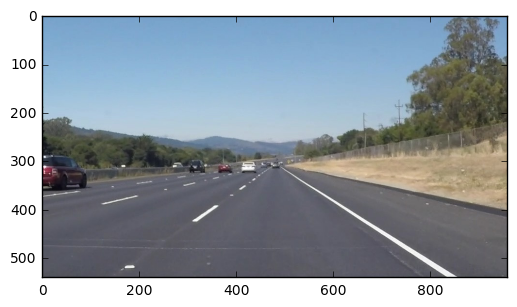

In [39]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  

`cv2.fillPoly()` for regions selection  

`cv2.line()` to draw lines on an image given endpoints  

`cv2.addWeighted()` to coadd / overlay two images

`cv2.cvtColor()` to grayscale or change color

`cv2.imwrite()` to output images to file  

`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [41]:
import math

DEBUG = False  # Set it to True if you want to print DEBUG information.

def transform_color_space(img, space='gray'):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    if space == 'gray':
        space_transform = cv2.COLOR_BGR2GRAY
    elif space == 'hsv':
        space_transform = cv2.COLOR_BGR2HSV
        
    return cv2.cvtColor(img, space_transform)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_region(img, vertices):
    """Draws the region of interest delimited by vertices on img"""
    masked_image = region_of_interest(img, vertices)
    plt.imshow(masked_image, cmap='hsv')
    

def get_slope(line):
    """Calculates the slope of a line"""
    x1,y1,x2,y2 = line
    return (y2 - y1) / (x2 - x1)

def build_line(slopes, xs, ys, y_min, y_max):
    """
    Builds a line that represents the average line of the input parameters.
    """

    if slopes != []:
        m = np.mean(slopes)
    else:
        m = 1

    if xs != []:
        x_mean = np.mean(xs)
    else:
        x_mean = 1

    if ys != []:
        y_mean = np.mean(ys)
    else:
        y_mean = y_min

    b = y_mean - m * x_mean
    x_max = (y_max - b) / m
    x_min = (y_min - b) / m
    
    if DEBUG:
        print("slopes:", slopes)
        print("m:", m)
        print("xs:", xs)
        print("x_mean:", x_mean)
        print("ys:", ys)
        print("y_mean:", y_mean)
        print("b:", b)
        print("x_max:",x_max)
        print("x_min:",x_min)
        
    return [x_min, y_min, x_max, y_max]
    
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    This function draws solid `lines` with `color` and `thickness`.
    """
    # Left lane accumulators.
    left_slopes = []
    left_xs = []
    left_ys = []
    
    # Right lane accumulators.
    right_slopes = []
    right_xs = []
    right_ys = []
    
    for l in lines:
        line = l[0]
        x1, y1, x2, y2 = line  # Unpack
        m = get_slope(line)
        
        # Only consider lines with slopes within this range. 
        if 0.2 <= abs(m) <= 0.8: 
            if m > 0:
                left_slopes.append(m)
                left_xs += [x1, x2]
                left_ys += [y1, y2]
            else:
                right_slopes.append(m)
                right_xs += [x1, x2]
                right_ys += [y1, y2]
            
    y_min_global = min(left_ys + right_ys)
    y_max_global = img.shape[0]

    
    # Build left line
    lx1, ly1, lx2, ly2 = build_line(left_slopes, left_xs, left_ys, y_min_global, y_max_global)

    # Build right line
    rx1, ry1, rx2, ry2 = build_line(right_slopes, right_xs, right_ys, y_min_global, y_max_global)

    
    if DEBUG:
        print("lx1:", lx1, "ly1:", ly1, "lx2:", lx2, "ly2:", ly2)
        print("rx1:", rx1, "ry1:", ry1, "rx2:", rx2, "ry2:", ry2)

    # Draw left and right lane lines.
    cv2.line(img, (math.floor(lx1), math.floor(ly1)), (math.floor(lx2), math.floor(ly2)), color, thickness)
    cv2.line(img, (math.ceil(rx1), math.ceil(ry1)), (math.ceil(rx2), math.ceil(ry2)), color, thickness)
    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns a blank image to draw on and an array of lines found by Hough Transform algorithm.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)

    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

Here's our pipeline definition:



In [42]:
def find_lane_lines(image, parameters=None):
    """
    Finds lane lines on a image of a road.
    
    The format of the parameters dict must be as follows (example):
    parameters = {
        # Canny Edge parameters.
        'low_threshold': 60,
        'high_threshold': 180,
        # Gaussian blur parameters.
        'kernel_size': 7,
        # Masked region parameters.
        'vertices': np.array([[(110, Y_length), (410, 350), (570, 350), (900, Y_length)]], dtype=np.int32),
        # Hough Transform parameters.
        'rho': 1,
        'theta': np.pi / 180,
        'hough_threshold': 10,
        'min_line_length': 15,
        'max_line_gap': 20
    }
    
    If parameters is None then defaults will be used. If only some paremeters are passed, they will be used along
    with defaults for those undefined values.
    """
    Y_length, X_length, _ = image.shape
    
    defaults = {
        'low_threshold': 50,
        'high_threshold': 150,
        'kernel_size': 3,
        'vertices':np.array([[(107, Y_length), (460, 311), (500, 311), (930, Y_length)]], dtype=np.int32),
        'rho': 1,
        'theta': np.pi / 180,
        'hough_threshold': 20,
        'min_line_length': 100,
        'max_line_gap': 160,
        'line_thickness': 3,
        'space': 'gray'
    }
    
    if not parameters:
        # Just use the defaults.
        params = defaults
    else:
        # Merge input parameters and defaults.
        params = {}
        params['low_threshold'] = parameters.get('low_threshold', defaults['low_threshold'])
        params['high_threshold'] = parameters.get('high_threshold', defaults['high_threshold'])
        params['kernel_size'] = parameters.get('kernel_size', defaults['kernel_size'])
        params['vertices'] = parameters.get('vertices', defaults['vertices'])
        params['rho'] = parameters.get('rho', defaults['rho'])
        params['theta'] = parameters.get('theta', defaults['theta'])
        params['hough_threshold'] = parameters.get('hough_threshold', defaults['hough_threshold'])
        params['min_line_length'] = parameters.get('min_line_length', defaults['min_line_length'])
        params['max_line_gap'] = parameters.get('max_line_gap', defaults['max_line_gap'])
        params['line_thickness'] = parameters.get('line_thickness', defaults['line_thickness'])
        params['space'] = parameters.get('space', defaults['space'])

    if DEBUG:
        print("PARAMETERS:", params)
        
    # Let's turn it into grayscale:
    transformed_image = transform_color_space(image, params['space'])
    
    # Now, let's blur it
    blurred_image = gaussian_blur(transformed_image, params['kernel_size'])
    
    # Apply Canny Edges transform:
    edges_image = canny(blurred_image, params['low_threshold'], params['high_threshold'])
    
    masked_image = region_of_interest(edges_image, params['vertices'])
    
    # Get the image and the lanes lines that'll be drawn on top of it.
    lines_img, lines = hough_lines(masked_image, params['rho'], params['theta'], params['hough_threshold'], params['min_line_length'], params['max_line_gap'])
    
    draw_lines(lines_img, lines, thickness=params['line_thickness'])
    
    # Return the original image with lane lines drawed on top of it.
    return weighted_img(lines_img, image)
    

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [43]:
import os
for img in os.listdir("test_images/"):
    image = mpimg.imread("test_images/" + img)
    Y_length, X_length, _ = image.shape    
    cv2.imwrite("test_images_copy/copy_" + img, find_lane_lines(image))

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [44]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [45]:
def process_image(image, parameters=None):
    """
    Takes an image of a road and draws lanes on top of it, which identify the lane lines.
    """
    if DEBUG and parameters and parameters['vertices'] != []:
        draw_region(image,parameters['vertices'])
    return find_lane_lines(image, parameters)

Let's try the one with the solid white lane on the right first ...

In [46]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:07<00:00, 25.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 50.1 s, sys: 488 ms, total: 50.6 s
Wall time: 8.47 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [47]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


 39%|███▉      | 269/682 [00:09<00:16, 24.39it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


___
_Although the current pipeline works well for the test videos and images, there are many places where further improvement would be very welcomed, starting for the overall elegance of the code. Most functions do not perform necessary checks on the input data, which leads to runtime errors very difficult to spot. It would be great to use a method to keep the lines a little bit steadier. One possible technique to explore is to take the average of each line on every frame._

_There are occassions where some wild NaNs emerge and impede the correct processing of the image. The region mask isn't very wide, so a different camera setting or placing would probably break the pipeline._

_The pipeline doesn't handle very well shadows on the road. As an example of this situation, you can reproduce the annotated challenge video and in the interval 00:04-00:06 the lines are all over the place._

_I found this project very challenging but fun and rewarding as well. I imagine this is not how a real Self Driven Car spot the lines on the road, so I'm really curious about the nature of the actual method. Nevertheless, it has been a great exercise._
___

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.57614213197969544, 0.60104986876640421, 0.60052219321148825, 0.67173252279635254, 0.57653061224489799, 0.70125786163522008, 0.57537688442211055, 0.66990291262135926, 0.60113960113960119, 0.64814814814814814, 0.60142348754448394]
m: 0.620293293137
xs: [653, 1047, 648, 1029, 645, 1028, 671, 1000, 651, 1043, 682, 1000, 655, 1053, 676, 779, 640, 991, 672, 996, 660, 941]
x_mean: 825.454545455
ys: [421, 648, 421, 650, 420, 650, 421, 642, 421, 647, 422, 645, 421, 650, 422, 491, 421, 632, 427, 637, 427, 596]
y_mean: 524.181818182
b: 12.1578998467
x_max: 1141.14098602
x_min: 657.49880688
slopes: [-0.67352941176470593, -0.67465753424657537, -0.67525773195876293, -0.6761

  0%|          | 0/251 [00:00<?, ?it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.57614213197969544, 0.60104986876640421, 0.60052219321148825, 0.67173252279635254, 0.57653061224489799, 0.70125786163522008, 0.57537688442211055, 0.66990291262135926, 0.60113960113960119, 0.64814814814814814, 0.60142348754448394]
m: 0.620293293137
xs: [653, 1047, 648, 1029, 645, 1028, 671, 1000, 651, 1043, 682, 1000, 655, 1053, 676, 779, 640, 991, 672, 996, 660, 941]
x_mean: 825.454545455
ys: [421, 648, 421, 650, 420, 650, 421, 642, 421, 647, 422, 645, 421, 650, 422, 491, 421, 632, 427, 637, 427, 596]
y_mean: 524.181818182
b: 12.1578998467
x_max: 1141.14098602
x_min: 657.49880688
slopes: [-0.67352941176470593, -0.67465753424657537, -0.67525773195876293, -0.6761

  1%|          | 2/251 [00:00<00:21, 11.66it/s]

slopes: [0.55388471177944865, 0.62285714285714289, 0.55504587155963303, 0.62457337883959041, 0.62199312714776633, 0.62341772151898733, 0.50797872340425532, 0.5533498759305211, 0.69899665551839463, 0.62465753424657533, 0.42499999999999999]
m: 0.5828867948
xs: [652, 1051, 680, 1030, 837, 1055, 666, 959, 671, 962, 670, 986, 613, 989, 645, 1048, 685, 984, 666, 1031, 604, 844]
x_mean: 833.090909091
ys: [428, 649, 432, 650, 529, 650, 420, 603, 422, 603, 427, 624, 421, 612, 425, 648, 421, 630, 422, 650, 426, 528]
y_mean: 528.181818182
b: 42.5841284046
x_max: 1162.17398925
x_min: 647.494290422
slopes: [-0.67365269461077848, -0.70158730158730154, -0.69936708860759489, -0.69811320754716977, -0.70157068062827221, -0.67359050445103863, -0.67267267267267272, -0.67164179104477617, -0.67492260061919507, -0.62645914396887159, -0.42519685039370081, -0.67500000000000004, -0.7816091954022989, -0.53125, -0.34482758620689657, -0.46621621621621623, -0.7021276595744681, -0.60087719298245612]
m: -0.6289267992

  1%|          | 3/251 [00:00<00:23, 10.69it/s]

slopes: [0.64672364672364668, 0.64948453608247425, 0.69780219780219777, 0.55223880597014929, 0.64857142857142858, 0.57766990291262132, 0.52941176470588236, 0.48447204968944102, 0.625, 0.64766839378238339]
m: 0.605904272624
xs: [672, 1023, 669, 863, 673, 855, 655, 856, 677, 1027, 658, 864, 622, 860, 601, 762, 669, 861, 671, 864]
x_mean: 770.1
ys: [420, 647, 420, 546, 421, 548, 431, 542, 422, 649, 422, 541, 422, 548, 431, 509, 427, 547, 420, 545]
y_mean: 492.9
b: 26.2931196522
x_max: 1144.91168274
x_min: 649.783964458
slopes: [-0.72516556291390732, -0.72727272727272729, -0.67352941176470593, -0.72468354430379744, -0.72555205047318616, -0.67682926829268297, -0.72390572390572394, -0.53092783505154639, -0.72483221476510062, -0.67261904761904767, -0.72789115646258506, -0.75362318840579712, -0.67532467532467533, -0.69811320754716977, -0.75272727272727269, -0.6730038022813688, -0.65200000000000002, -0.2857142857142857, -0.62464183381088823, -0.28703703703703703]
m: -0.651769692284
xs: [337, 63

  2%|▏         | 4/251 [00:00<00:24, 10.05it/s]

slopes: [0.67164179104477617, 0.69841269841269837, 0.31007751937984496, 0.70085470085470081, 0.70466321243523311]
m: 0.617129984425
xs: [678, 879, 672, 798, 608, 737, 684, 801, 682, 875]
x_mean: 741.4
ys: [422, 557, 421, 509, 422, 462, 427, 509, 420, 556]
y_mean: 470.5
b: 12.959829547
x_max: 1145.69084034
x_min: 659.569589431
slopes: [-0.6495726495726496, -0.69938650306748462, -0.70070422535211263, -0.70033670033670037, -0.70061728395061729, -0.70370370370370372, -0.71999999999999997, -0.70129870129870131, -0.67655786350148372, -0.69753086419753085, -0.65174129353233834, -0.64968152866242035, -0.70158730158730154, -0.69999999999999996, -0.72499999999999998, -0.7232142857142857]
m: -0.69380830653
xs: [304, 655, 332, 658, 378, 662, 360, 657, 340, 664, 384, 654, 309, 409, 440, 671, 336, 673, 316, 640, 373, 574, 327, 641, 331, 646, 410, 670, 418, 658, 310, 422]
x_mean: 488.1875
ys: [650, 422, 650, 422, 619, 420, 629, 421, 647, 420, 611, 421, 650, 578, 582, 420, 650, 422, 646, 420, 602, 471

  2%|▏         | 6/251 [00:00<00:23, 10.54it/s]

slopes: [0.62369337979094075, 0.67096774193548392, 0.62585034013605445, 0.67307692307692313, 0.62585034013605445]
m: 0.643887745015
xs: [678, 965, 672, 827, 673, 967, 722, 826, 674, 968]
x_mean: 797.2
ys: [428, 607, 423, 527, 423, 607, 456, 526, 423, 607]
y_mean: 502.7
b: -10.607310326
x_max: 1134.68118625
x_min: 670.314528685
slopes: [-0.67256637168141598, -0.67875647668393779, -0.67322834645669294, -0.72483221476510062, -0.67450980392156867, -0.65017667844522964, -0.60130718954248363, -0.64968152866242035, -0.64857142857142858, -0.69776119402985071, -0.67532467532467533, -0.61904761904761907, -0.67164179104477617, -0.67281105990783407, -0.65217391304347827, -0.72413793103448276, -0.6745762711864407, -0.64918032786885249, -0.44360902255639095]
m: -0.655468097041
xs: [310, 649, 471, 664, 396, 650, 357, 655, 409, 664, 393, 676, 507, 660, 366, 680, 339, 689, 375, 643, 510, 664, 333, 459, 380, 648, 436, 653, 337, 682, 546, 662, 358, 653, 376, 681, 568, 701]
x_mean: 531.578947368
ys: [650,

  3%|▎         | 8/251 [00:00<00:21, 11.08it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.64532019704433496, 0.59999999999999998, 0.60130718954248363, 0.6470588235294118, 0.59907834101382484, 0.64824120603015079, 0.24427480916030533]
m: 0.569325795189
xs: [666, 869, 665, 880, 727, 880, 672, 876, 662, 879, 668, 867, 603, 734]
x_mean: 760.571428571
ys: [421, 552, 422, 551, 457, 549, 420, 552, 421, 551, 423, 552, 426, 458]
y_mean: 482.5
b: 49.4870666308
x_max: 1177.73151864
x_min: 650.7924575
slopes: [-0.67352941176470593, -0.69846153846153847, -0.70061728395061729, -0.67448680351906154, -0.70270270270270274, -0.70121951219512191, -0.67365269461077848, -0.70256410256410251, -0.70121951219512191, -0.70149253731343286, -0.32380952380952382, -0.327102803

  4%|▍         | 10/251 [00:00<00:20, 11.52it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.62271062271062272, 0.59926470588235292, 0.59999999999999998, 0.62271062271062272, 0.59859154929577463, 0.60073260073260071, 0.60077519379844957]
m: 0.606397899304
xs: [661, 934, 677, 949, 665, 940, 663, 936, 665, 949, 675, 948, 688, 946]
x_mean: 806.857142857
ys: [423, 593, 429, 592, 421, 586, 423, 593, 420, 590, 429, 593, 438, 593]
y_mean: 508.785714286
b: 19.5092378184
x_max: 1155.16686813
x_min: 660.442199158
slopes: [-0.75328947368421051, -0.75328947368421051, -0.70030581039755346, -0.62459546925566345, -0.62457337883959041, -0.55390334572490707, -0.62643678160919536, -0.62578616352201255, -0.62453531598513012, -0.75415282392026584, -0.7533333333333333, -0

  5%|▍         | 12/251 [00:01<00:20, 11.83it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.57868020304568524, 0.64848484848484844, 0.64794007490636707, 0.64971751412429379, 0.55249999999999999, 0.64756446991404015, 0.55500000000000005, 0.55388471177944865, 0.64853556485355646, 0.54716981132075471]
m: 0.602947719843
xs: [656, 1050, 671, 1001, 681, 948, 675, 1029, 649, 1049, 672, 1021, 649, 1049, 644, 1043, 669, 908, 657, 763]
x_mean: 824.2
ys: [422, 650, 420, 634, 428, 601, 420, 650, 424, 645, 420, 646, 422, 644, 422, 643, 421, 576, 433, 491]
y_mean: 520.6
b: 23.6504893055
x_max: 1154.90860613
x_min: 657.353030206
slopes: [-0.69817073170731703, -0.72689075630252098, -0.72523961661341851, -0.72668810289389063, -0.69817073170731703, -0.7012987012987013

  6%|▌         | 14/251 [00:01<00:19, 12.06it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.5758354755784062, 0.625, 0.59999999999999998, 0.69871794871794868, 0.67647058823529416, 0.55405405405405406, 0.59999999999999998, 0.75624999999999998, 0.67500000000000004]
m: 0.640147562954
xs: [666, 1055, 672, 840, 663, 1033, 683, 839, 671, 841, 831, 1053, 842, 1032, 685, 845, 721, 841]
x_mean: 822.944444444
ys: [426, 650, 422, 527, 428, 650, 422, 531, 422, 537, 527, 650, 536, 650, 425, 546, 450, 531]
y_mean: 518.333333333
b: -8.47254722428
x_max: 1137.9759752
x_min: 669.334028622
slopes: [-0.69969040247678016, -0.75471698113207553, -0.75185185185185188, -0.70061728395061729, -0.75163398692810457, -0.70192307692307687, -0.75083056478405319, -0.698675496688741

  6%|▋         | 16/251 [00:01<00:19, 12.30it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.64928909952606639, 0.75652173913043474, 0.67647058823529416, 0.7192982456140351, 0.34636871508379891, 0.57547169811320753]
m: 0.620570014284
xs: [675, 886, 685, 800, 682, 886, 678, 792, 603, 782, 684, 896]
x_mean: 754.083333333
ys: [422, 559, 422, 509, 422, 560, 422, 504, 425, 487, 434, 556]
y_mean: 476.833333333
b: 8.87182839549
x_max: 1145.92738166
x_min: 662.500865561
slopes: [-0.75247524752475248, -0.7009345794392523, -0.7516556291390728, -0.75257731958762886, -0.75265017667844525, -0.69969040247678016, -0.46788990825688076, -0.7016574585635359, -0.69963369963369959, -0.46721311475409838, -0.75415282392026584, -0.32520325203252032, -0.75563909774436089, -0

  7%|▋         | 18/251 [00:01<00:18, 12.28it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.64685314685314688, 0.66874999999999996, 0.67293233082706772, 0.65217391304347827, 0.64874551971326166, 0.64912280701754388, 0.64748201438848918]
m: 0.655151390263
xs: [676, 962, 668, 828, 684, 950, 664, 825, 680, 959, 678, 963, 685, 963]
x_mean: 798.928571429
ys: [423, 608, 420, 527, 423, 602, 421, 526, 426, 607, 423, 608, 426, 606]
y_mean: 503.285714286
b: -20.1334500068
x_max: 1129.71362193
x_min: 671.80419144
slopes: [-0.72758620689655173, -0.72611464968152861, -0.57627118644067798, -0.70588235294117652, -0.72555205047318616, -0.72784810126582278, -0.64893617021276595, -0.67547169811320751, -0.34814814814814815, -0.72523961661341851, -0.7010309278350515, -0

  8%|▊         | 20/251 [00:01<00:18, 12.44it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.62325581395348839, 0.62149532710280375, 0.6216216216216216, 0.64766839378238339, 0.64974619289340096]
m: 0.632757469871
xs: [673, 888, 657, 871, 666, 888, 664, 857, 685, 882]
x_mean: 773.1
ys: [424, 558, 422, 555, 421, 559, 421, 546, 424, 552]
y_mean: 488.2
b: -0.984799957069
x_max: 1139.43309133
x_min: 665.317787624
slopes: [-0.75247524752475248, -0.69999999999999996, -0.75409836065573765, -0.75328947368421051, -0.75, -0.72499999999999998, -0.7533783783783784, -0.72549019607843135, -0.53216374269005851, -0.75247524752475248, -0.28695652173913044, -0.75641025641025639, -0.75084175084175087, -0.57931034482758625, -0.72680412371134018, -0.72222222222222221, -0.2

  9%|▉         | 22/251 [00:01<00:18, 12.72it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.57534246575342463, 0.625, 0.625, 0.60070671378091878, 0.59999999999999998, 0.57525083612040129, 0.57801418439716312, 0.55652173913043479, 0.57746478873239437]
m: 0.590366747546
xs: [654, 946, 658, 946, 659, 947, 671, 954, 676, 946, 655, 954, 667, 949, 674, 789, 670, 954]
x_mean: 798.277777778
ys: [422, 590, 422, 602, 421, 601, 424, 594, 424, 586, 421, 593, 424, 587, 424, 488, 432, 596]
y_mean: 502.833333333
b: 31.5566780284
x_max: 1166.12821578
x_min: 657.969514012
slopes: [-0.75496688741721851, -0.75250836120401343, -0.69875776397515532, -0.70188679245283014, -0.75247524752475248, -0.75084175084175087, -0.70125786163522008, -0.70038910505836571, -0.7284768211

 10%|▉         | 24/251 [00:01<00:18, 12.37it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.5764411027568922, 0.60194174757281549, 0.60052219321148825, 0.58196721311475408, 0.57868020304568524, 0.72463768115942029]
m: 0.61069835681
xs: [649, 1048, 923, 1026, 644, 1027, 659, 781, 652, 1046, 684, 822]
x_mean: 830.083333333
ys: [420, 650, 588, 650, 420, 650, 421, 492, 422, 650, 423, 523]
y_mean: 525.75
b: 18.8194723178
x_max: 1148.16180503
x_min: 656.920922102
slopes: [-0.69908814589665658, -0.72611464968152861, -0.72468354430379744, -0.70061728395061729, -0.72916666666666663, -0.72988505747126442, -0.72727272727272729, -0.70256410256410251, -0.72666666666666668, -0.72535211267605637, -0.72468354430379744, -0.40151515151515149, -0.72523961661341851, -0.

 10%|█         | 26/251 [00:02<00:17, 12.55it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.5757575757575758, 0.64756446991404015, 0.6470588235294118, 0.64873417721518989, 0.57721518987341769, 0.50909090909090904, 0.57723577235772361, 0.74814814814814812]
m: 0.616350633236
xs: [651, 1047, 677, 1026, 674, 997, 673, 989, 650, 1045, 618, 838, 658, 781, 707, 842]
x_mean: 804.5625
ys: [422, 650, 424, 650, 424, 633, 424, 629, 420, 648, 422, 534, 421, 492, 433, 534]
y_mean: 510.0
b: 14.1073936472
x_max: 1145.27765251
x_min: 658.541720355
slopes: [-0.78014184397163122, -0.78006872852233677, -0.72523961661341851, -0.78275862068965518, -0.7235494880546075, -0.77777777777777779, -0.48447204968944102, -0.77500000000000002, -0.48520710059171596, -0.42592592592592

 11%|█         | 28/251 [00:02<00:17, 12.72it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.70149253731343286, 0.6717557251908397, 0.59999999999999998, 0.50943396226415094, 0.34615384615384615, 0.67475728155339809, 0.6470588235294118]
m: 0.592950310858
xs: [683, 884, 671, 802, 678, 893, 648, 807, 610, 740, 687, 893, 677, 881]
x_mean: 753.857142857
ys: [423, 564, 424, 512, 431, 560, 422, 503, 420, 465, 423, 562, 431, 563]
y_mean: 478.785714286
b: 31.7858870861
x_max: 1160.66068322
x_min: 654.71609645
slopes: [-0.78006872852233677, -0.70033670033670037, -0.70046082949308752, -0.70370370370370372, -0.7803921568627451, -0.70063694267515919, -0.38317757009345793, -0.78006872852233677, -0.36363636363636365, -0.7008928571428571, -0.70202020202020199, -0.700

 12%|█▏        | 30/251 [00:02<00:17, 12.90it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.64745762711864407, 0.67326732673267331, 0.64900662251655628, 0.67434210526315785, 0.53543307086614178, 0.64846416382252559, 0.64919354838709675]
m: 0.63959492353
xs: [677, 972, 672, 975, 675, 977, 671, 975, 605, 732, 679, 972, 719, 967]
x_mean: 804.857142857
ys: [424, 615, 424, 628, 424, 620, 424, 629, 424, 492, 428, 618, 450, 611]
y_mean: 515.071428571
b: 0.288885833508
x_max: 1125.26082946
x_min: 656.213954686
slopes: [-0.7516556291390728, -0.70205479452054798, -0.75415282392026584, -0.70061728395061729, -0.70061728395061729, -0.50802139037433158, -0.51249999999999996, -0.70169491525423733, -0.70044052863436124, -0.75, -0.46153846153846156, -0.75390625, -0.7

 13%|█▎        | 32/251 [00:02<00:17, 12.45it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.62450592885375489, 0.62195121951219512, 0.62204724409448819, 0.62445414847161573, 0.62352941176470589, 0.628, 0.62204724409448819]
m: 0.623790742399
xs: [666, 919, 660, 906, 664, 918, 673, 902, 653, 908, 669, 919, 659, 913]
x_mean: 787.785714286
ys: [420, 578, 426, 579, 420, 578, 420, 563, 420, 579, 420, 577, 420, 578]
y_mean: 498.428571429
b: 7.01513586316
x_max: 1142.98724825
x_min: 662.056738048
slopes: [-0.69969040247678016, -0.75254237288135595, -0.7533333333333333, -0.7558528428093646, -0.69969040247678016, -0.51063829787234039, -0.50877192982456143, -0.65116279069767447, -0.49180327868852458, -0.7516556291390728, -0.7533333333333333, -0.2399999999999999

 14%|█▎        | 34/251 [00:02<00:17, 12.46it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.60066006600660071, 0.6257309941520468, 0.59800664451827246, 0.67399267399267404, 0.62285714285714289, 0.51048951048951052, 0.48684210526315791, 0.625, 0.38349514563106796]
m: 0.569674920323
xs: [659, 962, 843, 1014, 656, 957, 673, 946, 843, 1018, 626, 912, 669, 821, 658, 1026, 619, 825]
x_mean: 818.166666667
ys: [420, 602, 540, 647, 420, 600, 420, 604, 539, 648, 420, 566, 429, 503, 420, 650, 424, 503]
y_mean: 519.722222222
b: 53.6331915776
x_max: 1169.73169197
x_min: 643.115565302
slopes: [-0.67600000000000005, -0.7516556291390728, -0.67272727272727273, -0.67455621301775148, -0.69999999999999996, -0.67673716012084595, -0.67578125, -0.65137614678899081, -0.6755

 14%|█▍        | 36/251 [00:02<00:17, 12.06it/s]

slopes: [0.59999999999999998, 0.59893048128342241, 0.62397820163487738, 0.62397820163487738, 0.62745098039215685, 0.60113960113960119, 0.32520325203252032, 0.67361111111111116, 0.62331838565022424, 0.59999999999999998, 0.32592592592592595]
m: 0.5657760128
xs: [658, 1038, 668, 1042, 651, 1018, 653, 1020, 895, 997, 667, 1018, 608, 731, 666, 810, 673, 896, 683, 818, 606, 741]
x_mean: 798.045454545
ys: [421, 649, 426, 650, 421, 650, 421, 650, 574, 638, 421, 632, 421, 461, 421, 518, 431, 570, 434, 515, 423, 467]
y_mean: 509.727272727
b: 58.212297421
x_max: 1169.69911698
x_min: 639.453943599
slopes: [-0.70032573289902278, -0.67567567567567566, -0.70322580645161292, -0.70121951219512191, -0.70281124497991965, -0.69936708860759489, -0.67584097859327219, -0.46979865771812079, -0.69607843137254899, -0.67256637168141598, -0.42666666666666669, -0.70121951219512191, -0.42735042735042733, -0.67711598746081503, -0.53191489361702127]
m: -0.630745132498
xs: [350, 657, 311, 644, 352, 662, 332, 660, 405,

 15%|█▌        | 38/251 [00:03<00:17, 12.07it/s]

slopes: [0.57622739018087854, 0.6235955056179775, 0.69968051118210861, 0.67226890756302526, 0.57828282828282829, 0.64872521246458925, 0.69934640522875813, 0.70370370370370372, 0.70186335403726707, 0.7009345794392523]
m: 0.66046283977
xs: [657, 1044, 660, 1016, 676, 989, 671, 790, 647, 1043, 667, 1020, 675, 981, 684, 792, 680, 1002, 689, 1010]
x_mean: 819.65
ys: [427, 650, 426, 648, 420, 639, 421, 501, 420, 649, 421, 650, 420, 634, 424, 500, 420, 646, 424, 649]
y_mean: 519.45
b: -21.8983666175
x_max: 1123.30069452
x_min: 669.073776764
slopes: [-0.67448680351906154, -0.67559523809523814, -0.70031545741324919, -0.70121951219512191, -0.69817073170731703, -0.7021276595744681, -0.70270270270270274, -0.70129870129870131, -0.66917293233082709, -0.40714285714285714, -0.40384615384615385, -0.48795180722891568, -0.70030581039755346, -0.70229007633587781, -0.4891304347826087]
m: -0.627717125238
xs: [307, 648, 307, 643, 335, 652, 329, 657, 332, 660, 372, 654, 467, 652, 510, 664, 517, 650, 559, 699,

 16%|█▌        | 40/251 [00:03<00:17, 11.98it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.57638888888888884, 0.64782608695652177, 0.57653061224489799, 0.72499999999999998, 0.29230769230769232]
m: 0.56361065608
xs: [653, 941, 661, 891, 655, 1047, 687, 807, 605, 735]
x_mean: 768.2
ys: [420, 586, 421, 570, 420, 646, 428, 515, 424, 462]
y_mean: 489.2
b: 56.2342939997
x_max: 1177.70254845
x_min: 645.420206443
slopes: [-0.67352941176470593, -0.67441860465116277, -0.67584097859327219, -0.67441860465116277, -0.67557251908396942, -0.68000000000000005, -0.67551622418879054, -0.49162011173184356, -0.67450980392156867, -0.67465753424657537, -0.67359050445103863, -0.23076923076923078, -0.64841498559077815, -0.42608695652173911, -0.66666666666666663, -0.67352941

 17%|█▋        | 42/251 [00:03<00:19, 10.56it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.62461538461538457, 0.6237942122186495, 0.62462462462462465, 0.6005830903790087, 0.38095238095238093, 0.62538699690402477, 0.62420382165605093, 0.51041666666666663, 0.4861111111111111]
m: 0.566743143236
xs: [655, 980, 674, 985, 653, 986, 647, 990, 612, 738, 668, 991, 676, 990, 644, 932, 638, 854]
x_mean: 795.166666667
ys: [420, 623, 425, 619, 420, 628, 420, 626, 420, 468, 422, 624, 429, 625, 421, 568, 424, 529]
y_mean: 506.166666667
b: 55.5114106032
x_max: 1172.46868767
x_min: 643.128362022
slopes: [-0.62457337883959041, -0.67524115755627012, -0.67469879518072284, -0.62454873646209386, -0.67462686567164176, -0.69968051118210861, -0.67448680351906154, -0.6976744

 18%|█▊        | 44/251 [00:03<00:21,  9.48it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.6228070175438597, 0.59740259740259738, 0.59913793103448276, 0.48701298701298701, 0.3032258064516129, 0.50830564784053156, 0.59909909909909909, 0.36842105263157893, 0.48601398601398599]
m: 0.507936236115
xs: [656, 884, 663, 894, 665, 897, 627, 935, 599, 754, 634, 935, 675, 897, 610, 743, 606, 892]
x_mean: 753.666666667
ys: [421, 563, 422, 560, 422, 561, 420, 570, 430, 477, 420, 573, 430, 563, 423, 472, 424, 563]
y_mean: 484.111111111
b: 101.296501159
x_max: 1218.07316519
x_min: 627.447849121
slopes: [-0.70153846153846156, -0.69938650306748462, -0.70063694267515919, -0.64912280701754388, -0.65116279069767447, -0.64935064935064934, -0.65201465201465203, -0.699059

 18%|█▊        | 45/251 [00:03<00:22,  8.96it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.57839721254355403, 0.57638888888888884, 0.62132352941176472, 0.624, 0.62452107279693492, 0.62307692307692308, 0.50871080139372826, 0.55633802816901412, 0.62307692307692308, 0.60096153846153844, 0.24657534246575341, 0.53284671532846717]
m: 0.559684747968
xs: [652, 939, 650, 938, 659, 931, 679, 929, 675, 936, 675, 935, 645, 932, 653, 937, 674, 934, 723, 931, 600, 746, 657, 931]
x_mean: 790.041666667
ys: [420, 586, 421, 587, 423, 592, 436, 592, 420, 583, 426, 588, 428, 574, 427, 585, 426, 588, 452, 577, 427, 463, 427, 573]
y_mean: 500.875
b: 58.7007289076
x_max: 1181.55671294
x_min: 645.540676969
slopes: [-0.69969040247678016, -0.70061728395061729, -0.65116279069

 18%|█▊        | 46/251 [00:04<00:23,  8.65it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.57750759878419455, 0.6258278145695364, 0.50882352941176467, 0.69729729729729728, 0.78504672897196259, 0.62207357859531776, 0.46601941747572817]
m: 0.611799423587
xs: [651, 980, 660, 962, 627, 967, 674, 859, 686, 793, 666, 965, 854, 957]
x_mean: 807.214285714
ys: [420, 610, 423, 612, 420, 593, 420, 549, 420, 504, 426, 612, 541, 589]
y_mean: 509.928571429
b: 16.0753367177
x_max: 1150.58078864
x_min: 660.224001053
slopes: [-0.69938650306748462, -0.70121951219512191, -0.67378048780487809, -0.70099667774086383, -0.70186335403726707, -0.67301587301587307, -0.67045454545454541, -0.67448680351906154, -0.34615384615384615, -0.6728395061728395, -0.69999999999999996, -0.

 19%|█▉        | 48/251 [00:04<00:21,  9.34it/s]

slopes: [0.5934959349593496, 0.55527638190954776, 0.55205811138014527, 0.51081081081081081, 0.77952755905511806, 0.55454545454545456, 0.2283464566929134, 0.59946236559139787, 0.41916167664670656, 0.26857142857142857, 0.55393586005830908, 0.42236024844720499, 0.59999999999999998]
m: 0.510580945282
xs: [905, 1028, 642, 1040, 639, 1052, 625, 995, 686, 813, 644, 974, 608, 735, 657, 1029, 608, 775, 598, 773, 661, 1004, 617, 778, 908, 1013]
x_mean: 800.269230769
ys: [577, 650, 422, 643, 422, 650, 421, 610, 420, 519, 422, 605, 430, 459, 427, 650, 422, 492, 430, 477, 427, 617, 422, 490, 579, 642]
y_mean: 512.5
b: 103.897779674
x_max: 1206.66904243
x_min: 619.103049668
slopes: [-0.72668810289389063, -0.67567567567567566, -0.67462686567164176, -0.72602739726027399, -0.67584097859327219, -0.72555205047318616, -0.72555205047318616, -0.72698412698412695, -0.72608695652173916, -0.52631578947368418, -0.67405063291139244, -0.72844827586206895, -0.46616541353383456, -0.55675675675675673]
m: -0.66676936

 20%|█▉        | 50/251 [00:04<00:20,  9.69it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}


 20%|██        | 51/251 [00:04<00:21,  9.24it/s]

slopes: [0.72357723577235777, 0.62439024390243902, 0.37956204379562042, 0.64824120603015079, 0.62121212121212122, 0.67375886524822692]
m: 0.611790285993
xs: [673, 796, 673, 878, 612, 749, 678, 877, 672, 870, 734, 875]
x_mean: 757.25
ys: [420, 509, 426, 554, 422, 474, 425, 554, 431, 554, 459, 554]
y_mean: 481.833333333
b: 18.5551392648
x_max: 1146.54461961
x_min: 656.180508135
slopes: [-0.72843450479233229, -0.67455621301775148, -0.72929936305732479, -0.72555205047318616, -0.67474048442906576, -0.72881355932203384, -0.72611464968152861, -0.67680608365019013, -0.6738351254480287, -0.46583850931677018, -0.67489711934156382, -0.77981651376146788, -0.78048780487804881, -0.72727272727272729, -0.72483221476510062, -0.78238341968911918]
m: -0.704605021431
xs: [341, 654, 315, 653, 347, 661, 347, 664, 369, 658, 416, 652, 342, 656, 387, 650, 372, 651, 532, 693, 346, 589, 439, 657, 440, 645, 392, 645, 351, 649, 456, 649]
x_mean: 519.3125
ys: [650, 422, 650, 422, 649, 420, 650, 420, 615, 420, 594, 

 22%|██▏       | 54/251 [00:04<00:20,  9.45it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.60230547550432278, 0.59887005649717517, 0.64906832298136641, 0.27205882352941174, 0.6488294314381271, 0.46439628482972134]
m: 0.539254732463
xs: [661, 1008, 649, 1003, 677, 999, 606, 742, 699, 998, 610, 933]
x_mean: 798.75
ys: [420, 629, 421, 633, 424, 633, 426, 463, 440, 634, 423, 573]
y_mean: 509.916666667
b: 79.1869491116
x_max: 1188.33088022
x_min: 632.007528857
slopes: [-0.7263843648208469, -0.72468354430379744, -0.67256637168141598, -0.67509025270758127, -0.67352941176470593, -0.67551622418879054, -0.69803921568627447, -0.726457399103139, -0.78156996587030714, -0.48780487804878048, -0.48780487804878048, -0.72549019607843135, -0.72698412698412695, -0.4450

 22%|██▏       | 55/251 [00:04<00:20,  9.44it/s]

slopes: [0.60280373831775702, 0.62295081967213117, 0.59685863874345546, 0.59907834101382484, 0.67320261437908502, 0.57731958762886593]
m: 0.612035623293
xs: [661, 875, 682, 865, 672, 863, 649, 866, 718, 871, 680, 874]
x_mean: 773.0
ys: [421, 550, 438, 552, 430, 544, 422, 552, 449, 552, 438, 550]
y_mean: 491.5
b: 18.3964631949
x_max: 1146.34428145
x_min: 656.176734688
slopes: [-0.72555205047318616, -0.69938650306748462, -0.72756410256410253, -0.69847328244274809, -0.72857142857142854, -0.69938650306748462, -0.72680412371134018, -0.38297872340425532, -0.72611464968152861, -0.72555205047318616, -0.70032573289902278, -0.38732394366197181, -0.38461538461538464, -0.72468354430379744, -0.51388888888888884, -0.72761194029850751, -0.72477064220183485, -0.52727272727272723]
m: -0.640604234533
xs: [344, 661, 319, 645, 341, 653, 385, 647, 449, 659, 314, 640, 458, 652, 566, 707, 342, 656, 346, 663, 336, 643, 555, 697, 549, 679, 320, 636, 523, 667, 361, 629, 415, 633, 527, 637]
x_mean: 534.833333333

 24%|██▎       | 59/251 [00:05<00:19,  9.66it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.62393162393162394, 0.59876543209876543, 0.59880239520958078, 0.67500000000000004, 0.67449664429530198, 0.64777327935222673, 0.59876543209876543]
m: 0.631076400998
xs: [856, 973, 667, 991, 659, 993, 676, 956, 678, 976, 672, 919, 669, 993]
x_mean: 834.142857143
ys: [547, 620, 426, 620, 420, 620, 420, 609, 420, 621, 426, 586, 425, 619]
y_mean: 527.071428571
b: 0.663556367494
x_max: 1139.85635098
x_min: 664.478093254
slopes: [-0.72555205047318616, -0.7269076305220884, -0.69938650306748462, -0.72468354430379744, -0.72786885245901645, -0.70065789473684215, -0.72826086956521741, -0.69938650306748462, -0.70181818181818179, -0.72756410256410253, -0.72614107883817425, -

 24%|██▍       | 60/251 [00:05<00:19,  9.66it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.59999999999999998, 0.60360360360360366, 0.72727272727272729, 0.60064935064935066, 0.70138888888888884, 0.6223776223776224, 0.67224080267558528, 0.59944751381215466]
m: 0.64087256366
xs: [663, 1038, 914, 1025, 684, 970, 647, 955, 680, 968, 678, 964, 680, 979, 679, 1041]
x_mean: 847.8125
ys: [421, 646, 583, 650, 420, 628, 422, 607, 425, 627, 425, 603, 429, 630, 429, 646]
y_mean: 536.9375
b: -6.40227037799
x_max: 1133.45821239
x_min: 665.346426976
slopes: [-0.64942528735632188, -0.65088757396449703, -0.64855072463768115, -0.75247524752475248, -0.75328947368421051, -0.6506024096385542, -0.75100401606425704, -0.64872521246458925, -0.65042979942693413, -0.6761904761

 25%|██▌       | 64/251 [00:05<00:18, 10.37it/s]

slopes: [0.7232142857142857, 0.75, 0.64825581395348841, 0.72121212121212119, 0.59999999999999998, 0.62385321100917435, 0.5795053003533569]
m: 0.663720104606
xs: [687, 799, 689, 801, 684, 1028, 690, 855, 702, 1042, 705, 1032, 770, 1053]
x_mean: 824.071428571
ys: [427, 508, 424, 508, 427, 650, 423, 542, 442, 646, 438, 642, 486, 650]
y_mean: 515.214285714
b: -31.73848906
x_max: 1132.61370846
x_min: 680.615949291
slopes: [-0.75163398692810457, -0.75409836065573765, -0.69908814589665658, -0.70030581039755346, -0.64824120603015079, -0.75084175084175087, -0.532258064516129, -0.70175438596491224, -0.74853801169590639, -0.7558528428093646, -0.57999999999999996, -0.64912280701754388, -0.75342465753424659, -0.70121951219512191, -0.75238095238095237, -0.51111111111111107]
m: -0.686866975373
xs: [337, 643, 342, 647, 315, 644, 310, 637, 467, 666, 343, 640, 487, 673, 356, 641, 473, 644, 346, 645, 459, 659, 458, 629, 339, 631, 314, 642, 425, 635, 499, 679]
x_mean: 519.53125
ys: [650, 420, 650, 420, 65

 26%|██▋       | 66/251 [00:06<00:18,  9.87it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.64642857142857146, 0.6728395061728395, 0.64981949458483756, 0.62323943661971826, 0.64768683274021355]
m: 0.648002768309
xs: [676, 956, 673, 835, 678, 955, 669, 953, 675, 956]
x_mean: 802.6
ys: [420, 601, 420, 529, 420, 600, 426, 603, 420, 602]
y_mean: 504.1
b: -15.987021845
x_max: 1135.77758898
x_min: 672.816603828
slopes: [-0.69908814589665658, -0.7007299270072993, -0.67448680351906154, -0.67462686567164176, -0.6745762711864407, -0.70125786163522008, -0.70121951219512191, -0.67586206896551726, -0.67142857142857137, -0.69999999999999996, -0.72687224669603523, -0.46788990825688076, -0.70124481327800825, -0.69908814589665658]
m: -0.676312224402
xs: [336, 665, 37

 27%|██▋       | 68/251 [00:06<00:19,  9.56it/s]

slopes: [0.62318840579710144, 0.64948453608247425, 0.62211981566820274, 0.64903846153846156]
m: 0.635957804772
xs: [682, 889, 682, 876, 672, 889, 671, 879]
x_mean: 780.0
ys: [425, 554, 429, 555, 420, 555, 420, 555]
y_mean: 489.125
b: -6.92208772182
x_max: 1143.03509174
x_min: 671.30568179
slopes: [-0.62608695652173918, -0.72459016393442621, -0.69908814589665658, -0.67448680351906154, -0.6737160120845922, -0.6737160120845922, -0.70121951219512191, -0.67551622418879054, -0.67482517482517479, -0.67551622418879054, -0.70129870129870131, -0.75268817204301075, -0.67256637168141598, -0.6696428571428571, -0.70183486238532111]
m: -0.686452812933
xs: [329, 674, 340, 645, 340, 669, 310, 651, 313, 644, 315, 646, 337, 665, 337, 676, 370, 656, 309, 648, 353, 661, 333, 612, 534, 647, 530, 642, 392, 610]
x_mean: 506.266666667
ys: [636, 420, 648, 427, 650, 420, 650, 420, 650, 427, 650, 427, 650, 420, 649, 420, 625, 432, 650, 421, 637, 421, 630, 420, 503, 427, 502, 427, 609, 456]
y_mean: 524.133333333
b

 28%|██▊       | 70/251 [00:06<00:19,  9.37it/s]

slopes: [0.59863945578231292, 0.6223776223776224, 0.62240663900414939, 0.60084033613445376, 0.59999999999999998, 0.59915611814345993]
m: 0.60723669524
xs: [669, 963, 665, 951, 706, 947, 725, 963, 664, 959, 706, 943]
x_mean: 821.75
ys: [420, 596, 420, 598, 447, 597, 452, 595, 420, 597, 443, 585]
y_mean: 514.166666667
b: 15.1699123529
x_max: 1160.71721813
x_min: 666.675928547
slopes: [-0.72698412698412695, -0.72555205047318616, -0.67507886435331232, -0.72555205047318616, -0.67372881355932202, -0.67455621301775148, -0.67460317460317465, -0.72413793103448276, -0.72258064516129028, -0.72185430463576161, -0.67575757575757578]
m: -0.701853250005
xs: [341, 656, 345, 662, 318, 635, 346, 663, 416, 652, 316, 654, 395, 647, 505, 650, 502, 657, 504, 655, 319, 649]
x_mean: 522.136363636
ys: [650, 421, 650, 420, 650, 436, 650, 420, 579, 420, 648, 420, 597, 427, 538, 433, 538, 426, 541, 432, 650, 427]
y_mean: 516.954545455
b: 883.417649218
x_max: 232.837347718
x_min: 660.277129464
lx1: 666.675928547 l

 29%|██▊       | 72/251 [00:06<00:19,  9.17it/s]

slopes: [0.5768261964735516, 0.59999999999999998, 0.5768261964735516, 0.67420814479638014, 0.5761316872427984, 0.64615384615384619, 0.57971014492753625, 0.44339622641509435]
m: 0.58415655531
xs: [663, 1060, 658, 1038, 662, 1059, 680, 901, 667, 910, 685, 815, 666, 1011, 608, 820]
x_mean: 806.4375
ys: [421, 650, 422, 650, 421, 650, 420, 569, 425, 565, 431, 515, 421, 621, 421, 515]
y_mean: 507.3125
b: 36.2267479269
x_max: 1170.53082065
x_min: 656.969862932
slopes: [-0.72698412698412695, -0.72698412698412695, -0.69817073170731703, -0.69846153846153847, -0.72815533980582525, -0.69999999999999996, -0.72468354430379744, -0.7024793388429752, -0.69607843137254899, -0.26315789473684209, -0.72549019607843135, -0.72516556291390732, -0.69999999999999996, -0.72727272727272729]
m: -0.681648825676
xs: [346, 661, 350, 665, 324, 652, 324, 649, 348, 657, 373, 653, 351, 667, 534, 655, 545, 647, 580, 694, 461, 665, 353, 655, 447, 637, 468, 666]
x_mean: 536.678571429
ys: [650, 421, 650, 421, 650, 421, 647, 

 29%|██▉       | 73/251 [00:06<00:19,  9.28it/s]

slopes: [0.59999999999999998, 0.57650273224043713, 0.60106382978723405, 0.62269938650306744]
m: 0.600066487133
xs: [664, 1044, 668, 1034, 666, 1042, 672, 998]
x_mean: 848.5
ys: [422, 650, 422, 633, 424, 650, 422, 625]
y_mean: 531.0
b: 21.8435856679
x_max: 1163.46509812
x_min: 666.853461929
slopes: [-0.75247524752475248, -0.69938650306748462, -0.75254237288135595, -0.70158730158730154, -0.70333333333333337, -0.75362318840579712, -0.69846153846153847, -0.75494071146245056, -0.75109170305676853, -0.75185185185185188, -0.24528301886792453, -0.69999999999999996, -0.75247524752475248, -0.69846153846153847, -0.34969325153374231]
m: -0.671013787201
xs: [356, 659, 324, 650, 352, 647, 329, 644, 352, 652, 387, 663, 330, 655, 351, 604, 407, 636, 386, 656, 564, 670, 367, 637, 357, 660, 326, 651, 556, 719]
x_mean: 518.233333333
ys: [650, 422, 650, 422, 650, 428, 650, 429, 633, 422, 630, 422, 650, 423, 650, 459, 609, 437, 629, 426, 454, 428, 619, 430, 650, 422, 649, 422, 489, 432]
y_mean: 522.8666666

 31%|███       | 77/251 [00:07<00:18,  9.42it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.55400696864111498, 0.59999999999999998, 0.55438596491228065, 0.6454545454545455]
m: 0.588461869752
xs: [660, 947, 673, 933, 662, 947, 725, 835]
x_mean: 797.75
ys: [422, 581, 428, 584, 422, 580, 452, 523]
y_mean: 499.0
b: 29.5545434054
x_max: 1173.30534413
x_min: 663.501709566
slopes: [-0.69999999999999996, -0.75247524752475248, -0.75265017667844525, -0.75539568345323738, -0.69999999999999996, -0.69938650306748462, -0.69999999999999996, -0.7516556291390728, -0.75636363636363635, -0.7533783783783784, -0.27000000000000002, -0.75247524752475248, -0.69968051118210861, -0.75, -0.69999999999999996]
m: -0.699564067554
xs: [358, 658, 360, 663, 356, 639, 383, 661, 390, 

 31%|███       | 78/251 [00:07<00:21,  8.03it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.57746478873239437, 0.59999999999999998, 0.57674418604651168, 0.61971830985915488]
m: 0.59348182116
xs: [667, 880, 675, 1035, 665, 880, 718, 860]
x_mean: 797.5
ys: [421, 544, 428, 644, 421, 545, 453, 541]
y_mean: 499.625
b: 26.3232476253
x_max: 1168.82561124
x_min: 663.334138197
slopes: [-0.7533333333333333, -0.75328947368421051, -0.72477064220183485, -0.72607260726072609, -0.75163398692810457, -0.75247524752475248, -0.72668810289389063, -0.72523961661341851, -0.26923076923076922, -0.6512820512820513, -0.72649572649572647, -0.75547445255474455, -0.75250836120401343, -0.75862068965517238, -0.72268907563025209]
m: -0.703320275766
xs: [359, 659, 362, 666, 434, 652

 32%|███▏      | 80/251 [00:07<00:20,  8.45it/s]

slopes: [0.57851239669421484, 0.59913793103448276, 0.59913793103448276, 0.57534246575342463]
m: 0.588032681129
xs: [666, 908, 662, 894, 663, 895, 688, 907]
x_mean: 785.375
ys: [420, 560, 421, 560, 421, 560, 434, 560]
y_mean: 492.0
b: 30.1738330582
x_max: 1173.10855175
x_min: 662.932825763
slopes: [-0.77966101694915257, -0.72611464968152861, -0.72668810289389063, -0.78006872852233677, -0.78245614035087718, -0.58064516129032262, -0.72509960159362552, -0.77981651376146788, -0.78082191780821919, -0.72425249169435213, -0.44651162790697674, -0.67630057803468213, -0.67601246105919, -0.34234234234234234, -0.78172588832487311, -0.20155038759689922, -0.72357723577235777, -0.28712871287128711]
m: -0.64004297547
xs: [366, 661, 338, 652, 334, 645, 362, 653, 370, 655, 527, 682, 403, 654, 444, 662, 365, 657, 349, 650, 488, 703, 496, 669, 343, 664, 551, 662, 413, 610, 580, 709, 529, 652, 560, 661]
x_mean: 547.75
ys: [650, 420, 650, 422, 650, 424, 649, 422, 645, 422, 511, 421, 604, 422, 590, 420, 650, 

 33%|███▎      | 82/251 [00:07<00:18,  8.94it/s]

slopes: [0.53246753246753242, 0.55287009063444104, 0.50476190476190474, 0.53271028037383172]
m: 0.530702452059
xs: [651, 959, 647, 978, 614, 719, 650, 971]
x_mean: 773.625
ys: [421, 585, 422, 605, 421, 474, 422, 593]
y_mean: 492.875
b: 82.3103155255
x_max: 1201.59551176
x_min: 636.306998703
slopes: [-0.77966101694915257, -0.72784810126582278, -0.77966101694915257, -0.72756410256410253, -0.72284644194756553, -0.78260869565217395, -0.78156996587030714, -0.78228782287822873, -0.72611464968152861, -0.78205128205128205, -0.72932330827067671, -0.42307692307692307, -0.78277153558052437, -0.78321678321678323, -0.7814569536423841, -0.26767676767676768]
m: -0.709983460455
xs: [366, 661, 339, 655, 361, 656, 336, 648, 340, 607, 409, 662, 367, 660, 386, 657, 335, 649, 419, 653, 382, 648, 448, 708, 366, 633, 510, 653, 516, 667, 538, 736]
x_mean: 530.34375
ys: [650, 420, 650, 420, 650, 420, 649, 422, 650, 457, 618, 420, 649, 420, 633, 421, 650, 422, 604, 421, 618, 424, 543, 433, 646, 437, 541, 429, 5

 33%|███▎      | 84/251 [00:08<00:18,  9.20it/s]

slopes: [0.55319148936170215, 0.55483870967741933, 0.55319148936170215, 0.53054662379421225, 0.22857142857142856]
m: 0.484067948153
xs: [914, 1055, 663, 973, 915, 1056, 661, 972, 588, 833]
x_mean: 863.0
ys: [572, 650, 422, 594, 572, 650, 429, 594, 461, 517]
y_mean: 546.1
b: 128.349360744
x_max: 1222.24708641
x_min: 602.499381273
slopes: [-0.72580645161290325, -0.78091872791519434, -0.78245614035087718, -0.72698412698412695, -0.72784810126582278, -0.78021978021978022, -0.78156996587030714, -0.72380952380952379, -0.78358208955223885, -0.26984126984126983, -0.44144144144144143, -0.7807017543859649, -0.72653061224489801, -0.72834645669291342, -0.78277153558052437, -0.34722222222222221]
m: -0.680628137499
xs: [341, 651, 365, 648, 368, 653, 336, 651, 340, 656, 362, 635, 367, 660, 338, 653, 394, 662, 563, 689, 485, 707, 535, 649, 343, 588, 391, 645, 383, 650, 573, 717]
x_mean: 531.1875
ys: [650, 425, 649, 428, 650, 427, 650, 421, 650, 420, 650, 437, 650, 421, 649, 421, 632, 422, 455, 421, 523

 35%|███▍      | 87/251 [00:08<00:18,  9.08it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.59999999999999998, 0.23148148148148148]
m: 0.415740740741
xs: [670, 890, 579, 795]
x_mean: 733.5
ys: [421, 553, 447, 497]
y_mean: 479.5
b: 174.554166667
x_max: 1311.98552339
x_min: 590.381959911
slopes: [-0.72549019607843135, -0.75328947368421051, -0.72857142857142854, -0.75510204081632648, -0.72843450479233229, -0.75328947368421051, -0.75357142857142856, -0.75415282392026584, -0.25, -0.75423728813559321, -0.75328947368421051, -0.72843450479233229, -0.75518672199170123]
m: -0.707157642979
xs: [349, 655, 365, 669, 371, 651, 465, 661, 344, 657, 367, 671, 387, 667, 372, 673, 564, 700, 429, 665, 371, 675, 340, 653, 366, 607]
x_mean: 526.692307692
ys: [644, 422, 65

 35%|███▌      | 89/251 [00:08<00:18,  8.87it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.55305466237942125, 0.5317725752508361, 0.64417177914110424, 0.5119760479041916]
m: 0.560243766169
xs: [656, 967, 664, 963, 672, 835, 634, 968]
x_mean: 794.875
ys: [420, 592, 429, 588, 421, 526, 420, 591]
y_mean: 498.375
b: 53.0512363665
x_max: 1190.46173096
x_min: 654.980538459
slopes: [-0.78244274809160308, -0.78260869565217395, -0.75250836120401343, -0.78350515463917525, -0.78275862068965518, -0.75308641975308643, -0.75247524752475248, -0.75503355704697983, -0.75347222222222221, -0.36578947368421055, -0.78109452736318408, -0.26666666666666666, -0.78006872852233677, -0.75352112676056338, -0.75666666666666671, -0.72602739726027399, -0.7528089887640449, -0.7247

 36%|███▋      | 91/251 [00:08<00:18,  8.52it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.59813084112149528, 0.57727272727272727, 0.21076233183856502, 0.62318840579710144, 0.57711442786069655, 0.30463576158940397]
m: 0.481850749247
xs: [660, 874, 665, 885, 607, 830, 668, 875, 684, 885, 600, 751]
x_mean: 748.666666667
ys: [422, 550, 422, 549, 469, 516, 421, 550, 432, 548, 428, 474]
y_mean: 481.75
b: 121.004405731
x_max: 1243.11437765
x_min: 620.514951438
slopes: [-0.78006872852233677, -0.78181818181818186, -0.78095238095238095, -0.78125, -0.26923076923076922, -0.38192419825072887, -0.77906976744186052, -0.77941176470588236, -0.77777777777777779, -0.46531791907514453, -0.22950819672131148, -0.38242894056847543, -0.38291139240506328]
m: -0.58243615519

 37%|███▋      | 93/251 [00:09<00:18,  8.75it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.55471698113207546, 0.57608695652173914, 0.55405405405405406, 0.57692307692307687, 0.57608695652173914, 0.48031496062992124, 0.26530612244897961, 0.55633802816901412]
m: 0.51747839205
xs: [658, 923, 665, 941, 657, 953, 653, 939, 667, 943, 411, 538, 523, 719, 668, 952]
x_mean: 738.125
ys: [421, 568, 428, 587, 421, 585, 422, 587, 428, 587, 570, 631, 494, 546, 428, 586]
y_mean: 518.0625
b: 136.098761868
x_max: 1128.35868531
x_min: 548.624333873
slopes: [-0.77891156462585032, -0.78008298755186722, -0.23076923076923078, -0.78048780487804881, -0.78350515463917525, -0.62411347517730498, -0.2309278350515464, -0.26843657817109146, -0.64963503649635035, -0.24107142857142

 38%|███▊      | 95/251 [00:09<00:17,  9.10it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.57772020725388606, 0.55481727574750828, 0.55438596491228065, 0.57837837837837835]
m: 0.566325456573
xs: [666, 1052, 678, 979, 680, 965, 675, 1045]
x_mean: 842.5
ys: [427, 650, 431, 598, 431, 589, 431, 645]
y_mean: 525.25
b: 48.1208028372
x_max: 1186.38353506
x_min: 656.652800694
slopes: [-0.78082191780821919, -0.78006872852233677, -0.78231292517006801, -0.78048780487804881, -0.78169014084507038, -0.72523961661341851, -0.23035230352303523, -0.67549668874172186, -0.70048309178743962, -0.778169014084507]
m: -0.701512223197
xs: [353, 645, 351, 642, 316, 610, 354, 641, 360, 644, 304, 617, 383, 752, 472, 623, 414, 621, 366, 650]
x_mean: 505.9
ys: [650, 422, 648, 421

 39%|███▊      | 97/251 [00:09<00:17,  9.04it/s]

slopes: [0.57702349869451697, 0.5758354755784062, 0.46402877697841727, 0.59999999999999998, 0.59800664451827246]
m: 0.562978879154
xs: [655, 1038, 668, 1057, 623, 901, 689, 1054, 682, 983]
x_mean: 835.0
ys: [420, 641, 426, 650, 420, 549, 430, 649, 430, 610]
y_mean: 522.5
b: 52.4126359065
x_max: 1185.81245019
x_min: 652.932779016
slopes: [-0.44262295081967212, -0.55203619909502266]
m: -0.497329574957
xs: [336, 519, 437, 658]
x_mean: 487.5
ys: [638, 557, 557, 435]
y_mean: 546.75
b: 789.198167792
x_max: 139.139458573
x_min: 742.36117533
lx1: 652.932779016 ly1: 420 lx2: 1185.81245019 ly2: 720
rx1: 742.36117533 ry1: 420 rx2: 139.139458573 ry2: 720
PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.50729927007299269

 39%|███▉      | 99/251 [00:09<00:17,  8.47it/s]

slopes: [0.24647887323943662, 0.26746987951807227, 0.42553191489361702, 0.34146341463414637, 0.6972111553784861, 0.55342465753424652, 0.40520446096654272]
m: 0.419540622309
xs: [425, 709, 488, 903, 611, 799, 596, 801, 675, 926, 666, 1031, 600, 869]
x_mean: 721.357142857
ys: [557, 627, 537, 648, 420, 500, 433, 503, 420, 595, 433, 635, 429, 538]
y_mean: 519.642857143
b: 217.004232521
x_max: 1198.92029694
x_min: 483.852472643
slopes: [-0.75496688741721851, -0.75328947368421051, -0.75163398692810457, -0.75403225806451613, -0.22829581993569131, -0.75438596491228072, -0.75362318840579712]
m: -0.678603939907
xs: [345, 647, 346, 650, 353, 659, 394, 642, 623, 934, 356, 641, 353, 629]
x_mean: 540.857142857
ys: [649, 421, 649, 420, 650, 420, 608, 421, 645, 574, 649, 434, 642, 434]
y_mean: 544.0
b: 911.02778807
x_max: 281.501147924
x_min: 723.585230196
lx1: 483.852472643 ly1: 420 lx2: 1198.92029694 ly2: 720
rx1: 723.585230196 ry1: 420 rx2: 281.501147924 ry2: 720
PARAMETERS: {'max_line_gap': 160, '

 40%|████      | 101/251 [00:09<00:17,  8.34it/s]

slopes: [0.46534653465346537, 0.62538699690402477, 0.53191489361702127, 0.50967741935483868, 0.6253968253968254, 0.6484375]
m: 0.567693361654
xs: [622, 824, 714, 1037, 636, 918, 610, 765, 717, 1032, 684, 812]
x_mean: 780.916666667
ys: [420, 514, 447, 649, 420, 570, 420, 499, 450, 647, 431, 514]
y_mean: 498.416666667
b: 55.0954589947
x_max: 1171.2388869
x_min: 642.784583462
slopes: [-0.75451263537906132, -0.78468899521531099, -0.30188679245283018, -0.22994652406417113, -0.78113207547169816, -0.30158730158730157, -0.78500000000000003, -0.59880239520958078]
m: -0.567194589922
xs: [352, 629, 433, 642, 347, 559, 464, 838, 369, 634, 364, 553, 388, 588, 366, 700]
x_mean: 514.125
ys: [641, 432, 584, 420, 627, 563, 647, 561, 627, 420, 623, 566, 621, 464, 621, 421]
y_mean: 552.375
b: 843.983918544
x_max: 218.591504127
x_min: 747.510512401
lx1: 642.784583462 ly1: 420 lx2: 1171.2388869 ly2: 720
rx1: 747.510512401 ry1: 420 rx2: 218.591504127 ry2: 720
PARAMETERS: {'max_line_gap': 160, 'hough_thresho

 41%|████      | 103/251 [00:10<00:18,  7.96it/s]

slopes: [0.59876543209876543, 0.55500000000000005, 0.31896551724137934, 0.55384615384615388, 0.34579439252336447]
m: 0.474474299142
xs: [685, 1009, 811, 1011, 819, 935, 728, 858, 749, 856]
x_mean: 846.1
ys: [431, 625, 514, 625, 603, 640, 461, 533, 497, 534]
y_mean: 546.3
b: 144.847295496
x_max: 1212.18937579
x_min: 579.910661129
slopes: [-0.78368794326241131, -0.77966101694915257, -0.7829181494661922, -0.62557077625570778, -0.2441860465116279, -0.78358208955223885]
m: -0.666601003666
xs: [341, 623, 335, 630, 342, 623, 369, 588, 330, 502, 349, 617]
x_mean: 470.75
ys: [650, 429, 650, 420, 648, 428, 601, 464, 648, 606, 648, 438]
y_mean: 552.5
b: 866.302422476
x_max: 219.475250819
x_min: 669.51957771
lx1: 579.910661129 ly1: 420 lx2: 1212.18937579 ly2: 720
rx1: 669.51957771 ry1: 420 rx2: 219.475250819 ry2: 720
PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices':

 42%|████▏     | 105/251 [00:10<00:17,  8.56it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.55384615384615388, 0.55343511450381677, 0.53113553113553114, 0.6470588235294118]
m: 0.571368905754
xs: [650, 910, 648, 910, 626, 899, 716, 869]
x_mean: 778.5
ys: [420, 564, 420, 565, 420, 565, 451, 550]
y_mean: 494.375
b: 49.5643068707
x_max: 1173.38498189
x_min: 648.330158325
slopes: [-0.75409836065573765, -0.77889447236180909, -0.78125, -0.73043478260869565]
m: -0.761169403907
xs: [336, 641, 441, 640, 342, 630, 397, 627]
x_mean: 506.75
ys: [650, 420, 575, 420, 650, 425, 603, 435]
y_mean: 522.25
b: 907.97259543
x_max: 246.952379411
x_min: 641.08277727
lx1: 648.330158325 ly1: 420 lx2: 1173.38498189 ly2: 720
rx1: 641.08277727 ry1: 420 rx2: 246.952379411 ry2: 72

 42%|████▏     | 106/251 [00:10<00:16,  8.58it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.55428571428571427, 0.52755905511811019, 0.55587392550143266, 0.62213740458015265, 0.55397727272727271, 0.30314960629921262]
m: 0.519497163085
xs: [648, 998, 859, 986, 650, 999, 673, 935, 646, 998, 739, 993]
x_mean: 843.666666667
ys: [421, 615, 549, 616, 420, 614, 427, 590, 421, 616, 539, 616]
y_mean: 537.0
b: 98.717560077
x_max: 1195.93038051
x_min: 618.448882406
slopes: [-0.22935779816513763, -0.22857142857142856, -0.625, -0.20535714285714285, -0.50684931506849318, -0.64754098360655743]
m: -0.407112778045
xs: [676, 785, 631, 876, 487, 671, 685, 797, 333, 479, 357, 479]
x_mean: 604.666666667
ys: [555, 530, 606, 550, 535, 420, 558, 535, 649, 575, 650, 571]
y_me

 43%|████▎     | 109/251 [00:10<00:17,  8.32it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.51428571428571423, 0.50887573964497046, 0.26732673267326734, 0.62195121951219512, 0.50967741935483868, 0.44573643410852715, 0.59999999999999998, 0.28727272727272729, 0.57676348547717837, 0.36686390532544377, 0.59375]
m: 0.481136670696
xs: [920, 1025, 879, 1048, 759, 860, 611, 857, 887, 1042, 768, 1026, 659, 954, 762, 1037, 613, 854, 808, 977, 678, 806]
x_mean: 855.909090909
ys: [586, 640, 556, 642, 574, 601, 426, 579, 559, 638, 526, 641, 420, 597, 571, 650, 434, 573, 554, 616, 435, 511]
y_mean: 560.409090909
b: 148.599840491
x_max: 1187.60467516
x_min: 564.081218579
slopes: [-0.72425249169435213, -0.78137651821862353, -0.24583333333333332, -0.78228782287822873

 44%|████▍     | 110/251 [00:11<00:17,  8.20it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.75177304964539005, 0.62535211267605639, 0.5304347826086957, 0.62372881355932208, 0.42608695652173911, 0.5533498759305211, 0.64893617021276595, 0.40163934426229508, 0.70078740157480313, 0.40764331210191085, 0.65000000000000002]
m: 0.574521074463
xs: [655, 937, 671, 1026, 725, 840, 658, 953, 862, 977, 651, 1054, 668, 950, 857, 979, 573, 827, 725, 882, 725, 825]
x_mean: 819.090909091
ys: [427, 639, 425, 647, 582, 643, 420, 604, 594, 643, 427, 650, 420, 603, 594, 643, 470, 648, 581, 645, 575, 640]
y_mean: 569.090909091
b: 98.5059199171
x_max: 1081.76028297
x_min: 559.586226464
slopes: [-0.75415282392026584, -0.72596153846153844, -0.75409836065573765, -0.6516129032

 45%|████▍     | 112/251 [00:11<00:20,  6.91it/s]

slopes: [0.62385321100917435, 0.69999999999999996, 0.22950819672131148]
m: 0.51778713591
xs: [687, 1014, 674, 774, 534, 656]
x_mean: 723.166666667
ys: [434, 638, 423, 493, 600, 628]
y_mean: 536.0
b: 161.553602881
x_max: 1078.52505091
x_min: 504.930267646
slopes: [-0.75308641975308643, -0.70037453183520604, -0.78339350180505418, -0.70161290322580649, -0.70149253731343286, -0.78014184397163122, -0.6741071428571429, -0.70161290322580649, -0.7007299270072993, -0.77973568281938321]
m: -0.727628739381
xs: [387, 630, 359, 626, 342, 619, 375, 623, 357, 558, 340, 622, 346, 570, 376, 624, 432, 569, 391, 618]
x_mean: 488.2
ys: [612, 429, 617, 430, 648, 431, 604, 430, 619, 478, 650, 430, 628, 477, 604, 430, 574, 478, 608, 431]
y_mean: 530.4
b: 885.628350566
x_max: 227.62755455
x_min: 635.802745998
lx1: 504.930267646 ly1: 423 lx2: 1078.52505091 ly2: 720
rx1: 635.802745998 ry1: 423 rx2: 227.62755455 ry2: 720
PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017

 45%|████▌     | 113/251 [00:11<00:19,  7.10it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.55343511450381677, 0.62307692307692308, 0.53183520599250933]
m: 0.569449081191
xs: [658, 920, 665, 795, 656, 923]
x_mean: 769.5
ys: [421, 566, 420, 501, 421, 563]
y_mean: 482.0
b: 43.8089320235
x_max: 1187.44781634
x_min: 660.62283776
slopes: [-0.75409836065573765, -0.70219435736677116, -0.70157068062827221, -0.62702702702702706, -0.70143884892086328, -0.7010309278350515, -0.62576687116564422, -0.69999999999999996, -0.72549019607843135]
m: -0.693179696631
xs: [321, 626, 308, 627, 444, 635, 456, 641, 360, 638, 325, 616, 474, 637, 332, 642, 326, 632]
x_mean: 502.222222222
ys: [650, 420, 644, 420, 558, 424, 539, 423, 619, 424, 631, 427, 526, 424, 640, 423, 647, 4

 46%|████▌     | 116/251 [00:11<00:16,  8.22it/s]

slopes: [0.57547169811320753, 0.6470588235294118, 0.75, 0.57720588235294112]
m: 0.637434100999
xs: [682, 1000, 699, 818, 694, 794, 730, 1002]
x_mean: 802.375
ys: [430, 613, 437, 514, 425, 500, 456, 613]
y_mean: 498.5
b: -12.961186789
x_max: 1149.86190045
x_min: 680.793804581
slopes: [-0.70196078431372544, -0.65137614678899081, -0.64851485148514854, -0.70034843205574915, -0.70153846153846156, -0.64851485148514854, -0.67647058823529416, -0.69945355191256831]
m: -0.678522208477
xs: [378, 633, 414, 632, 429, 631, 348, 635, 314, 639, 410, 612, 343, 649, 463, 646]
x_mean: 511.0
ys: [602, 423, 565, 423, 554, 423, 624, 423, 650, 422, 568, 437, 628, 421, 549, 421]
y_mean: 508.3125
b: 855.037348532
x_max: 199.016844025
x_min: 639.680386447
lx1: 680.793804581 ly1: 421 lx2: 1149.86190045 ly2: 720
rx1: 639.680386447 ry1: 421 rx2: 199.016844025 ry2: 720
PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 

 47%|████▋     | 118/251 [00:12<00:15,  8.59it/s]

slopes: [0.57454545454545458, 0.57664233576642332, 0.59793814432989689, 0.59895833333333337]
m: 0.587021066994
xs: [665, 940, 668, 942, 664, 858, 663, 855]
x_mean: 781.875
ys: [425, 583, 425, 583, 425, 541, 425, 540]
y_mean: 493.375
b: 34.3979032442
x_max: 1167.93439845
x_min: 656.879485996
slopes: [-0.67448680351906154, -0.70158730158730154, -0.67462686567164176, -0.70175438596491224, -0.69811320754716977, -0.70070422535211263, -0.67326732673267331, -0.70037453183520604, -0.65126050420168069, -0.37962962962962965, -0.69968051118210861]
m: -0.659589572111
xs: [300, 641, 324, 639, 308, 643, 406, 634, 323, 641, 352, 636, 529, 630, 365, 632, 353, 591, 320, 428, 329, 642]
x_mean: 484.818181818
ys: [650, 420, 649, 428, 646, 420, 589, 429, 650, 428, 628, 429, 498, 430, 624, 437, 613, 458, 637, 596, 647, 428]
y_mean: 533.363636364
b: 853.144653461
x_max: 201.859852081
x_min: 656.688146349
lx1: 656.879485996 ly1: 420 lx2: 1167.93439845 ly2: 720
rx1: 656.688146349 ry1: 420 rx2: 201.859852081 ry

 47%|████▋     | 119/251 [00:12<00:15,  8.38it/s]

slopes: [0.57720588235294112, 0.59925093632958804, 0.55230125523012552, 0.36301369863013699, 0.59925093632958804, 0.625, 0.38, 0.50980392156862742]
m: 0.525728328805
xs: [652, 924, 648, 915, 634, 873, 610, 756, 650, 917, 688, 920, 607, 757, 635, 992]
x_mean: 761.125
ys: [420, 577, 420, 580, 422, 554, 425, 478, 420, 580, 435, 580, 423, 480, 427, 609]
y_mean: 489.375
b: 89.2300257382
x_max: 1199.80214058
x_min: 629.165209745
slopes: [-0.72698412698412695, -0.67164179104477617, -0.651685393258427, -0.6506024096385542, -0.72549019607843135, -0.67352941176470593, -0.72580645161290325, -0.72426470588235292]
m: -0.693750560783
xs: [325, 640, 307, 642, 469, 647, 480, 646, 323, 629, 301, 641, 514, 638, 344, 616]
x_mean: 510.125
ys: [650, 421, 647, 422, 546, 430, 538, 430, 650, 428, 650, 421, 510, 420, 637, 440]
y_mean: 515.0
b: 868.899504819
x_max: 214.629743364
x_min: 647.061826246
lx1: 629.165209745 ly1: 420 lx2: 1199.80214058 ly2: 720
rx1: 647.061826246 ry1: 420 rx2: 214.629743364 ry2: 720
P

 49%|████▉     | 123/251 [00:12<00:14,  9.00it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.57692307692307687, 0.59999999999999998, 0.5764411027568922, 0.72377622377622375, 0.77884615384615385, 0.72791519434628971, 0.67218543046357615]
m: 0.66515531173
xs: [651, 1041, 656, 1031, 652, 1051, 694, 980, 700, 804, 696, 979, 682, 984]
x_mean: 828.642857143
ys: [420, 645, 425, 650, 420, 650, 432, 639, 432, 513, 432, 638, 434, 637]
y_mean: 526.214285714
b: -24.9619122417
x_max: 1119.98190363
x_min: 668.959421047
slopes: [-0.65000000000000002, -0.64800000000000002, -0.64571428571428569, -0.67532467532467533, -0.65086206896551724, -0.67584097859327219, -0.64634146341463417, -0.64925373134328357, -0.67625899280575541, -0.59863945578231292, -0.64978902953586493,

 50%|████▉     | 125/251 [00:12<00:15,  8.36it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.57512953367875652, 0.60052219321148825, 0.55392156862745101, 0.62326869806094187, 0.59940652818991103, 0.62395543175487467, 0.57435897435897432, 0.59763313609467461]
m: 0.593524507997
xs: [649, 842, 645, 1028, 634, 838, 655, 1016, 661, 998, 658, 1017, 647, 842, 677, 846]
x_mean: 790.8125
ys: [420, 531, 420, 650, 420, 533, 420, 645, 421, 623, 421, 645, 420, 532, 430, 531]
y_mean: 503.875
b: 34.5084000195
x_max: 1154.95079099
x_min: 649.495673365
slopes: [-0.67352941176470593, -0.64978902953586493, -0.67448680351906154, -0.64853556485355646, -0.50420168067226889, -0.6517857142857143, -0.64678899082568808]
m: -0.63558817078
xs: [306, 646, 402, 639, 303, 644, 401,

 51%|█████     | 127/251 [00:13<00:15,  8.13it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.62445414847161573, 0.75, 0.62337662337662336, 0.69756097560975605, 0.67231638418079098]
m: 0.673541626328
xs: [664, 893, 679, 803, 664, 895, 667, 872, 713, 890]
x_mean: 774.0
ys: [421, 564, 421, 514, 420, 564, 420, 563, 446, 565]
y_mean: 489.8
b: -31.5212187777
x_max: 1115.77546124
x_min: 670.368691597
slopes: [-0.67537313432835822, -0.65086206896551724, -0.67448680351906154, -0.6741573033707865, -0.67448680351906154, -0.45161290322580644, -0.64804469273743015]
m: -0.635574815667
xs: [376, 644, 406, 638, 306, 647, 376, 643, 305, 646, 551, 675, 421, 600]
x_mean: 516.714285714
ys: [601, 420, 571, 420, 650, 420, 600, 420, 650, 420, 477, 421, 560, 444]
y_mean: 505

 51%|█████     | 128/251 [00:13<00:16,  7.46it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.62222222222222223, 0.64802631578947367, 0.62222222222222223, 0.6253968253968254, 0.77777777777777779]
m: 0.659129072682
xs: [661, 976, 659, 963, 663, 978, 651, 966, 684, 810]
x_mean: 801.1
ys: [421, 617, 421, 618, 421, 617, 421, 618, 422, 520]
y_mean: 509.6
b: -18.4283001253
x_max: 1120.30910292
x_min: 666.680197154
slopes: [-0.67492260061919507, -0.67256637168141598, -0.625, -0.64984227129337535, -0.67543859649122806, -0.67582417582417587]
m: -0.662265669318
xs: [317, 640, 304, 643, 425, 641, 337, 654, 530, 644, 466, 648]
x_mean: 520.75
ys: [640, 422, 650, 422, 557, 422, 627, 421, 499, 422, 545, 422]
y_mean: 504.083333333
b: 848.958180631
x_max: 194.722732289

 52%|█████▏    | 130/251 [00:13<00:19,  6.15it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.67298578199052128, 0.60082304526748975, 0.59909909909909909, 0.67195767195767198, 0.57983193277310929, 0.69999999999999996]
m: 0.637449588515
xs: [672, 883, 657, 900, 677, 899, 691, 880, 651, 889, 714, 884]
x_mean: 783.083333333
ys: [423, 565, 421, 567, 431, 564, 437, 564, 421, 559, 446, 565]
y_mean: 496.916666667
b: -2.25948193935
x_max: 1133.04564777
x_min: 663.988948405
slopes: [-0.67256637168141598, -0.62745098039215685, -0.67391304347826086, -0.67484662576687116, -0.60180995475113119, -0.69955156950672648]
m: -0.658356424263
xs: [302, 641, 435, 639, 320, 642, 303, 629, 429, 650, 421, 644]
x_mean: 504.583333333
ys: [650, 422, 550, 422, 639, 422, 649, 429, 

 53%|█████▎    | 132/251 [00:13<00:17,  6.96it/s]

slopes: [0.64682539682539686, 0.59999999999999998, 0.62592592592592589, 0.70232558139534884, 0.64980544747081714, 0.59999999999999998]
m: 0.637480391936
xs: [666, 918, 654, 939, 655, 925, 708, 923, 675, 932, 738, 938]
x_mean: 805.916666667
ys: [426, 589, 420, 591, 422, 591, 440, 591, 424, 591, 469, 589]
y_mean: 511.916666667
b: -1.83940586795
x_max: 1132.33193522
x_min: 661.72922525
slopes: [-0.67455621301775148, -0.62605042016806722, -0.62871287128712872, -0.7263843648208469, -0.67567567567567566, -0.27927927927927926, -0.67610062893081757]
m: -0.612394207597
xs: [305, 643, 406, 644, 440, 642, 332, 639, 332, 628, 547, 658, 313, 631]
x_mean: 511.428571429
ys: [650, 422, 571, 422, 548, 421, 644, 421, 631, 431, 467, 436, 646, 431]
y_mean: 510.071428571
b: 823.267323314
x_max: 168.628837492
x_min: 658.509369147
lx1: 661.72922525 ly1: 420 lx2: 1132.33193522 ly2: 720
rx1: 658.509369147 ry1: 420 rx2: 168.628837492 ry2: 720
PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickn

 53%|█████▎    | 133/251 [00:14<00:22,  5.32it/s]

slopes: [0.59942363112391928, 0.64864864864864868, 0.60056657223796039, 0.64766839378238339, 0.64880952380952384, 0.6506024096385542, 0.64985163204747776, 0.59999999999999998]
m: 0.630696351411
xs: [662, 1009, 666, 999, 688, 1041, 692, 885, 668, 1004, 690, 1022, 670, 1007, 663, 1033]
x_mean: 837.4375
ys: [424, 632, 423, 639, 438, 650, 434, 559, 423, 641, 434, 650, 423, 642, 424, 646]
y_mean: 530.125
b: 1.9562242152
x_max: 1138.49362562
x_min: 662.828911012
slopes: [-0.67469879518072284, -0.62580645161290327, -0.5539906103286385, -0.20779220779220781, -0.6690647482014388, -0.6243386243386243, -0.67549668874172186, -0.43925233644859812, -0.62416107382550334]
m: -0.566066837386
xs: [308, 640, 445, 600, 444, 657, 562, 716, 504, 643, 437, 626, 321, 623, 548, 655, 473, 622]
x_mean: 545.777777778
ys: [644, 420, 542, 445, 543, 425, 462, 430, 513, 420, 548, 430, 634, 430, 478, 431, 523, 430]
y_mean: 486.0
b: 794.946700582
x_max: 132.399030701
x_min: 662.371783363
lx1: 662.828911012 ly1: 420 lx2

 53%|█████▎    | 134/251 [00:14<00:19,  5.94it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.62727272727272732, 0.60212201591511938, 0.59946949602122013, 0.62376237623762376, 0.72222222222222221, 0.60212201591511938, 0.62]
m: 0.628138693369
xs: [911, 1021, 664, 1041, 663, 1040, 919, 1020, 711, 819, 665, 1042, 714, 914]
x_mean: 867.428571429
ys: [581, 650, 423, 650, 424, 650, 587, 650, 441, 519, 423, 650, 455, 579]
y_mean: 548.714285714
b: 3.84883626608
x_max: 1140.11630121
x_min: 662.514772815
slopes: [-0.65158371040723984, -0.64953271028037385, -0.64768683274021355, -0.60233918128654973, -0.60355029585798814, -0.64981949458483756]
m: -0.63408537086
xs: [409, 630, 428, 642, 354, 635, 472, 643, 460, 629, 356, 633]
x_mean: 524.25
ys: [573, 429, 559, 420

 54%|█████▍    | 136/251 [00:14<00:16,  6.94it/s]

slopes: [0.67222222222222228, 0.64634146341463417, 0.6485623003194888]
m: 0.655708661985
xs: [672, 852, 696, 860, 707, 1020]
x_mean: 801.166666667
ys: [425, 546, 439, 545, 445, 648]
y_mean: 508.0
b: -17.3319230273
x_max: 1124.48098641
x_min: 668.485790168
slopes: [-0.64983164983164987, -0.64963503649635035, -0.6216216216216216, -0.21428571428571427, -0.2857142857142857, -0.26428571428571429, -0.6257309941520468, -0.38194444444444442, -0.62637362637362637, -0.32608695652173914, -0.62420382165605093]
m: -0.479064896853
xs: [348, 645, 367, 641, 452, 637, 548, 716, 552, 657, 549, 689, 463, 634, 551, 695, 453, 635, 546, 684, 420, 577]
x_mean: 566.318181818
ys: [614, 421, 600, 422, 537, 422, 468, 432, 463, 433, 465, 428, 529, 422, 476, 421, 536, 422, 475, 430, 566, 468]
y_mean: 475.0
b: 746.303161359
x_max: 54.9052154134
x_min: 679.037774414
lx1: 668.485790168 ly1: 421 lx2: 1124.48098641 ly2: 720
rx1: 679.037774414 ry1: 421 rx2: 54.9052154134 ry2: 720
PARAMETERS: {'max_line_gap': 160, 'hough

 56%|█████▌    | 140/251 [00:14<00:13,  8.17it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.64784053156146182, 0.62222222222222223, 0.37988826815642457, 0.53185595567867039, 0.64726027397260277, 0.27160493827160492, 0.3253012048192771]
m: 0.489424770669
xs: [656, 957, 659, 974, 613, 792, 626, 987, 669, 961, 619, 781, 613, 779]
x_mean: 763.285714286
ys: [422, 617, 422, 618, 422, 490, 423, 615, 429, 618, 429, 473, 420, 474]
y_mean: 490.857142857
b: 117.286207188
x_max: 1231.47382179
x_min: 618.509341892
slopes: [-0.64900662251655628, -0.625, -0.65000000000000002, -0.64970059880239517, -0.62439024390243902, -0.30201342281879195, -0.4044943820224719, -0.72566371681415931, -0.62313432835820892, -0.32298136645962733, -0.4044943820224719]
m: -0.54371627852


 57%|█████▋    | 142/251 [00:15<00:12,  8.64it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.62445414847161573, 0.64573991031390132, 0.64734299516908211, 0.6228070175438597, 0.59876543209876543, 0.20930232558139536, 0.3632075471698113, 0.55343511450381677]
m: 0.533131811357
xs: [660, 889, 657, 880, 656, 863, 661, 889, 667, 829, 608, 780, 613, 825, 619, 881]
x_mean: 748.5625
ys: [422, 565, 422, 566, 423, 557, 422, 564, 421, 518, 439, 475, 423, 500, 420, 565]
y_mean: 481.375
b: 82.2925184614
x_max: 1196.15349892
x_min: 633.440875868
slopes: [-0.62457337883959041, -0.62633451957295372, -0.34104046242774566, -0.64795918367346939, -0.30303030303030304, -0.625, -0.60237388724035612, -0.3235294117647059, -0.21019108280254778, -0.59999999999999998, -0.4666666

 57%|█████▋    | 144/251 [00:15<00:11,  9.06it/s]

{'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.60212201591511938, 0.62637362637362637, 0.60052910052910058, 0.62534435261707988, 0.55350553505535061, 0.60135135135135132, 0.48553054662379419, 0.26470588235294118]
m: 0.544932801352
xs: [653, 1030, 649, 1013, 652, 1030, 650, 1013, 666, 937, 655, 803, 623, 934, 616, 752]
x_mean: 792.25
ys: [420, 647, 421, 649, 421, 648, 421, 648, 421, 571, 420, 509, 420, 571, 425, 461]
y_mean: 504.5625
b: 72.8394881286
x_max: 1187.59691152
x_min: 637.070315844
slopes: [-0.6015625, -0.53333333333333333, -0.55384615384615388, -0.48927038626609443, -0.28522336769759449, -0.6237942122186495, -0.36257309941520466, -0.6028368794326241, -0.26724137931034481, -0.30841121495327101, -0.46391752577

 58%|█████▊    | 146/251 [00:15<00:11,  9.41it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.62362637362637363, 0.60054347826086951, 0.62362637362637363, 0.59891598915989164, 0.34385964912280703, 0.46473029045643155, 0.23046092184368738, 0.28342245989304815, 0.38208955223880597, 0.52884615384615385, 0.62310030395136773, 0.62420382165605093]
m: 0.493952113973
xs: [652, 1016, 667, 1035, 650, 1014, 653, 1022, 592, 877, 633, 874, 492, 991, 607, 794, 594, 929, 619, 827, 660, 989, 671, 985]
x_mean: 785.125
ys: [423, 650, 429, 650, 423, 650, 422, 643, 435, 533, 421, 533, 509, 624, 427, 480, 442, 570, 420, 530, 430, 635, 420, 616]
y_mean: 513.125
b: 125.310846517
x_max: 1203.94090168
x_min: 596.594579003
slopes: [-0.60062893081761004, -0.625, -0.4216216216216

 59%|█████▊    | 147/251 [00:15<00:12,  8.33it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.44244604316546765, 0.42574257425742573, 0.28632478632478631, 0.38305084745762713, 0.44363636363636366, 0.5071942446043165, 0.24632352941176472, 0.25, 0.36269430051813473, 0.50996015936254979, 0.44444444444444442, 0.26760563380281688, 0.34432234432234432, 0.60056657223796039, 0.40304182509505704]
m: 0.394490244576
xs: [593, 871, 609, 811, 592, 826, 456, 751, 592, 867, 642, 920, 433, 705, 459, 875, 617, 810, 601, 852, 625, 814, 611, 753, 583, 856, 659, 1012, 450, 713]
x_mean: 698.6
ys: [435, 558, 423, 509, 438, 505, 534, 647, 436, 558, 420, 561, 577, 644, 534, 638, 420, 490, 429, 557, 422, 506, 420, 458, 463, 557, 438, 650, 539, 645]
y_mean: 513.7
b: 238.1091151

 59%|█████▉    | 149/251 [00:16<00:15,  6.40it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.6987951807228916, 0.20942408376963351, 0.26490066225165565, 0.70038910505836571, 0.30857142857142855, 0.60069444444444442, 0.67579908675799083, 0.65017667844522964, 0.28365384615384615, 0.60077519379844957, 0.30493273542600896, 0.23333333333333334, 0.50862068965517238]
m: 0.464620497568
xs: [670, 919, 592, 783, 617, 768, 646, 903, 609, 784, 637, 925, 703, 922, 700, 983, 603, 811, 674, 932, 593, 816, 604, 754, 612, 960]
x_mean: 750.769230769
ys: [421, 595, 437, 477, 423, 463, 420, 600, 421, 475, 421, 594, 443, 591, 420, 604, 432, 491, 444, 599, 435, 503, 425, 460, 423, 600]
y_mean: 485.269230769
b: 136.44645721
x_max: 1255.97890288
x_min: 610.290644244
slopes: 

 60%|█████▉    | 150/251 [00:16<00:15,  6.73it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.55342465753424652, 0.21182266009852216, 0.40384615384615385, 0.21238938053097345, 0.24838012958963282, 0.40174672489082969, 0.21212121212121213, 0.72664359861591699, 0.30622009569377989, 0.62390670553935856, 0.57432432432432434, 0.23412698412698413, 0.4044943820224719]
m: 0.39334207761
xs: [599, 964, 590, 793, 619, 827, 587, 813, 507, 970, 615, 844, 590, 788, 683, 972, 602, 811, 644, 987, 692, 840, 575, 827, 634, 812]
x_mean: 737.884615385
ys: [433, 635, 438, 481, 420, 504, 444, 492, 520, 635, 420, 512, 435, 477, 425, 635, 455, 519, 420, 634, 440, 525, 446, 505, 420, 492]
y_mean: 490.846153846
b: 200.605086194
x_max: 1320.46618801
x_min: 557.771279236
slopes: 

 61%|██████    | 152/251 [00:16<00:16,  6.10it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.23012552301255229, 0.21311475409836064, 0.75503355704697983, 0.48571428571428571, 0.59842519685039375, 0.25, 0.75141242937853103, 0.72483221476510062, 0.64976958525345618, 0.75268817204301075, 0.42528735632183906, 0.5535714285714286]
m: 0.532497875255
xs: [606, 845, 521, 887, 677, 975, 628, 908, 644, 898, 493, 765, 691, 868, 668, 966, 685, 902, 696, 975, 612, 873, 611, 891]
x_mean: 761.875
ys: [458, 513, 487, 565, 420, 645, 421, 557, 424, 576, 515, 583, 436, 569, 425, 641, 435, 576, 436, 646, 421, 532, 421, 576]
y_mean: 511.583333333
b: 105.886514624
x_max: 1153.26936297
x_min: 589.886833306
slopes: [-0.67462686567164176, -0.69961977186311786, -0.6475644699140

 62%|██████▏   | 155/251 [00:16<00:12,  7.52it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.5768194070080862, 0.2300469483568075, 0.62390670553935856, 0.62463343108504399, 0.46456692913385828, 0.625, 0.46594982078853048, 0.75565610859728505, 0.64759036144578308, 0.36254980079681276, 0.30246913580246915, 0.60227272727272729, 0.34355828220858897, 0.62548262548262545, 0.21518987341772153]
m: 0.497712810462
xs: [613, 984, 510, 936, 655, 998, 655, 996, 633, 887, 659, 995, 617, 896, 603, 824, 650, 982, 635, 886, 607, 769, 627, 979, 586, 912, 663, 922, 617, 775]
x_mean: 769.033333333
ys: [420, 634, 498, 596, 420, 634, 421, 634, 421, 539, 421, 631, 420, 550, 427, 594, 420, 635, 448, 539, 422, 471, 422, 634, 443, 555, 420, 582, 437, 471]
y_mean: 505.3
b: 122.

 63%|██████▎   | 157/251 [00:17<00:11,  8.18it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.48604651162790696, 0.40079365079365081, 0.44556962025316454, 0.42213114754098363, 0.44556962025316454, 0.38461538461538464, 0.44473007712082263, 0.42379182156133827, 0.44477611940298506, 0.75352112676056338]
m: 0.465154507993
xs: [607, 1037, 628, 880, 609, 1004, 624, 868, 605, 1000, 600, 873, 600, 989, 608, 877, 625, 960, 685, 969]
x_mean: 782.4
ys: [439, 648, 434, 535, 439, 615, 424, 527, 439, 615, 427, 532, 440, 613, 421, 535, 455, 604, 424, 638]
y_mean: 510.2
b: 146.263112946
x_max: 1233.43292862
x_min: 588.48593822
slopes: [-0.55303030303030298, -0.42587601078167114, -0.53164556962025311, -0.55462184873949583, -0.55384615384615388, -0.55254237288135588, -0

 63%|██████▎   | 159/251 [00:17<00:10,  8.39it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.77978339350180503, 0.46551724137931033, 0.21167883211678831, 0.67301587301587307, 0.72799999999999998, 0.30357142857142855, 0.62457337883959041, 0.30508474576271188, 0.55149501661129563, 0.67378048780487809, 0.33783783783783783, 0.625, 0.38297872340425532, 0.38509316770186336, 0.72427983539094654]
m: 0.518112664129
xs: [691, 968, 613, 1019, 484, 1032, 646, 961, 682, 932, 585, 921, 675, 968, 554, 967, 672, 973, 625, 953, 630, 778, 575, 831, 593, 922, 594, 916, 686, 929]
x_mean: 779.166666667
ys: [428, 644, 447, 636, 516, 632, 428, 640, 420, 602, 461, 563, 431, 614, 475, 601, 432, 598, 420, 641, 421, 471, 465, 625, 437, 563, 434, 558, 430, 606]
y_mean: 521.3
b: 

 64%|██████▍   | 161/251 [00:17<00:10,  8.66it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.44362745098039214, 0.72586872586872586, 0.72426470588235292, 0.78165938864628826, 0.62352941176470589, 0.26650943396226418, 0.57478005865102644, 0.22761194029850745, 0.6996699669966997, 0.7276785714285714, 0.28099173553719009]
m: 0.552381035456
xs: [595, 1003, 718, 977, 687, 959, 678, 907, 622, 962, 575, 999, 631, 972, 475, 743, 652, 955, 735, 959, 618, 739]
x_mean: 780.045454545
ys: [436, 617, 445, 633, 429, 626, 429, 608, 430, 642, 516, 629, 441, 637, 526, 587, 430, 642, 462, 625, 444, 478]
y_mean: 532.363636364
b: 101.481320479
x_max: 1119.73192383
x_min: 576.628557239
slopes: [-0.53303964757709255, -0.21095334685598377, -0.50909090909090904, -0.50867052023

 65%|██████▍   | 162/251 [00:17<00:10,  8.80it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.64927536231884053, 0.64896755162241893, 0.32307692307692309, 0.67462686567164176, 0.69968051118210861, 0.67492260061919507, 0.40547263681592038, 0.64954682779456197, 0.50955414012738853, 0.6502890173410405, 0.24698795180722891, 0.28517110266159695, 0.64985163204747776, 0.4041095890410959, 0.4825174825174825, 0.62427745664739887, 0.57792207792207795, 0.21171171171171171]
m: 0.520442302274
xs: [672, 1017, 672, 1011, 595, 855, 620, 955, 609, 922, 621, 944, 541, 943, 685, 1016, 584, 898, 608, 954, 841, 1007, 516, 1042, 687, 1024, 568, 1006, 862, 1005, 667, 1013, 644, 952, 792, 1014]
x_mean: 815.611111111
ys: [422, 646, 429, 649, 459, 543, 420, 646, 421, 640, 432, 

 66%|██████▌   | 165/251 [00:18<00:09,  9.16it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.67241379310344829, 0.6470588235294118, 0.67381974248927035, 0.60096153846153844, 0.53020134228187921, 0.49162011173184356, 0.64809384164222872, 0.4885245901639344, 0.625, 0.60194174757281549, 0.67365269461077848, 0.34554973821989526]
m: 0.583236496984
xs: [670, 902, 694, 915, 680, 913, 599, 807, 613, 911, 626, 805, 616, 957, 599, 904, 659, 915, 601, 807, 610, 944, 526, 717]
x_mean: 749.583333333
ys: [425, 581, 436, 579, 424, 581, 428, 553, 423, 581, 422, 510, 425, 646, 432, 581, 420, 580, 428, 552, 423, 648, 495, 561]
y_mean: 505.583333333
b: 68.3989758025
x_max: 1117.21579079
x_min: 602.844688245
slopes: [-0.5535714285714286, -0.57661290322580649, -0.53051643

 67%|██████▋   | 167/251 [00:18<00:09,  9.25it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.64857142857142858, 0.59946236559139787, 0.60224089635854339, 0.60053619302949057, 0.64912280701754388, 0.75247524752475248, 0.69818181818181824, 0.38386308068459657, 0.6495726495726496, 0.48499999999999999, 0.67063492063492058, 0.60185185185185186, 0.77862595419847325]
m: 0.624626093324
xs: [658, 1008, 653, 1025, 655, 1012, 652, 1025, 676, 1018, 629, 831, 596, 871, 574, 983, 688, 805, 544, 744, 663, 915, 897, 1005, 609, 871]
x_mean: 792.576923077
ys: [422, 649, 423, 646, 422, 637, 423, 647, 426, 648, 421, 573, 436, 628, 477, 634, 435, 511, 494, 591, 421, 590, 583, 648, 426, 630]
y_mean: 532.346153846
b: 37.2819267255
x_max: 1093.00280691
x_min: 612.715474689
s

 67%|██████▋   | 169/251 [00:18<00:09,  8.47it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.62465753424657533, 0.647887323943662, 0.62295081967213117, 0.78125, 0.65042979942693413, 0.72575250836120397, 0.77826086956521734, 0.26490066225165565, 0.55263157894736847, 0.62546816479400746, 0.57563025210084029, 0.46946564885496184, 0.72607260726072609, 0.6470588235294118, 0.62454873646209386]
m: 0.621131021961
xs: [664, 1029, 653, 1008, 662, 1028, 584, 808, 660, 1009, 604, 903, 587, 817, 612, 763, 582, 848, 678, 945, 585, 823, 594, 856, 600, 903, 682, 937, 589, 866]
x_mean: 762.633333333
ys: [422, 650, 420, 650, 422, 650, 440, 615, 423, 650, 429, 646, 440, 619, 424, 464, 442, 589, 434, 601, 447, 584, 465, 588, 428, 648, 436, 601, 475, 648]
y_mean: 525.0
b:

 68%|██████▊   | 171/251 [00:18<00:10,  7.91it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.30281690140845069, 0.67431192660550454, 0.64903846153846156, 0.26797385620915032, 0.65022421524663676, 0.48742138364779874, 0.62536023054755041, 0.32061068702290074, 0.64905660377358487, 0.72636815920398012, 0.60465116279069764]
m: 0.541621235272
xs: [614, 756, 657, 875, 662, 870, 607, 760, 654, 877, 599, 917, 598, 945, 608, 739, 590, 855, 673, 874, 705, 877]
x_mean: 741.454545455
ys: [420, 463, 420, 567, 421, 556, 422, 463, 422, 567, 468, 623, 431, 648, 428, 470, 439, 611, 421, 567, 453, 557]
y_mean: 492.590909091
b: 91.0033822836
x_max: 1161.32192897
x_min: 607.429318297
slopes: [-0.62464985994397759, -0.5993975903614458, -0.62465753424657533, -0.60060975609

 69%|██████▉   | 173/251 [00:19<00:10,  7.67it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.62416107382550334, 0.60135135135135132, 0.21052631578947367, 0.2303370786516854, 0.48780487804878048, 0.4894894894894895, 0.20000000000000001, 0.48598130841121495, 0.2288329519450801, 0.23058252427184467, 0.67500000000000004, 0.30625000000000002, 0.36144578313253012, 0.67391304347826086, 0.4890282131661442, 0.42535211267605633]
m: 0.420003507765
xs: [644, 942, 651, 947, 598, 769, 608, 786, 583, 911, 577, 910, 609, 769, 590, 911, 472, 909, 491, 903, 583, 863, 550, 870, 625, 791, 663, 939, 579, 898, 554, 909]
x_mean: 731.375
ys: [421, 607, 423, 601, 430, 466, 437, 478, 479, 639, 479, 642, 436, 468, 482, 638, 547, 647, 547, 642, 441, 630, 498, 596, 420, 480, 422,

 69%|██████▉   | 174/251 [00:19<00:09,  8.21it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.6009174311926605, 0.62272727272727268, 0.62244897959183676, 0.57677902621722843, 0.59905660377358494, 0.53201970443349755, 0.59999999999999998, 0.57499999999999996, 0.72340425531914898, 0.6733668341708543, 0.48979591836734693]
m: 0.601410547799
xs: [657, 875, 652, 872, 670, 866, 573, 840, 663, 875, 646, 849, 666, 876, 575, 775, 615, 803, 677, 876, 578, 823]
x_mean: 741.0
ys: [421, 552, 422, 559, 432, 554, 476, 630, 426, 553, 441, 549, 426, 552, 479, 594, 421, 557, 424, 558, 473, 593]
y_mean: 504.181818182
b: 58.5366022625
x_max: 1099.85333672
x_min: 601.026036308
slopes: [-0.64809384164222872, -0.65000000000000002, -0.67431192660550454, -0.64978902953586493, -

 70%|███████   | 176/251 [00:19<00:08,  8.70it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.64814814814814814, 0.62406015037593987, 0.62406015037593987, 0.59927797833935015, 0.78008298755186722, 0.21241050119331742, 0.62553191489361704, 0.64777327935222673, 0.22727272727272727]
m: 0.554290870834
xs: [667, 937, 678, 944, 677, 943, 664, 941, 613, 854, 466, 885, 709, 944, 676, 923, 614, 724]
x_mean: 769.944444444
ys: [421, 596, 425, 591, 425, 591, 430, 596, 423, 611, 555, 644, 443, 590, 428, 588, 423, 448]
y_mean: 512.666666667
b: 85.893490062
x_max: 1143.99594744
x_min: 602.76386915
slopes: [-0.70061728395061729, -0.69969040247678016, -0.64963503649635035, -0.64942528735632188, -0.65182186234817818, -0.65032679738562094, -0.64741641337386013, -0.699275

 71%|███████▏  | 179/251 [00:19<00:08,  8.83it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.6235955056179775, 0.59842519685039375, 0.6495726495726496, 0.53086419753086422, 0.64809384164222872, 0.62151394422310757, 0.22935779816513763, 0.72693726937269376]
m: 0.578545050372
xs: [669, 1025, 664, 1045, 672, 1023, 617, 1022, 676, 1017, 683, 934, 614, 723, 613, 884]
x_mean: 805.0625
ys: [428, 650, 421, 649, 420, 648, 420, 635, 429, 650, 428, 584, 420, 445, 424, 621]
y_mean: 517.0
b: 51.235075385
x_max: 1155.94269484
x_min: 637.400534976
slopes: [-0.70061728395061729, -0.65030674846625769, -0.69969040247678016, -0.64838709677419359, -0.65000000000000002, -0.69899665551839463, -0.69938650306748462, -0.65151515151515149, -0.69846153846153847, -0.698305084745

 72%|███████▏  | 180/251 [00:19<00:07,  9.14it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.625, 0.59946949602122013, 0.59999999999999998, 0.62534435261707988, 0.72608695652173916, 0.61864406779661019, 0.59999999999999998, 0.78240740740740744, 0.3251231527093596]
m: 0.611341714786
xs: [674, 1026, 667, 1044, 674, 1009, 664, 1027, 607, 837, 679, 797, 665, 980, 616, 832, 456, 659]
x_mean: 772.944444444
ys: [430, 650, 422, 648, 427, 628, 423, 650, 464, 631, 420, 493, 423, 612, 470, 639, 552, 618]
y_mean: 533.333333333
b: 60.8001512324
x_max: 1078.28376966
x_min: 587.559854137
slopes: [-0.67272727272727273, -0.6737160120845922, -0.69999999999999996, -0.69969040247678016, -0.69846153846153847, -0.67148014440433212, -0.70042194092827004, -0.6694214876033057

 73%|███████▎  | 183/251 [00:20<00:07,  8.80it/s]

slopes: [0.55241935483870963, 0.70036101083032487, 0.25, 0.6711711711711712, 0.59999999999999998, 0.22972972972972974, 0.22910216718266255, 0.55284552845528456, 0.28205128205128205, 0.6009174311926605, 0.22950819672131148, 0.44919786096256686]
m: 0.445608644428
xs: [644, 892, 680, 957, 614, 754, 603, 825, 673, 893, 617, 765, 570, 893, 644, 890, 607, 763, 676, 894, 618, 740, 604, 791]
x_mean: 733.625
ys: [422, 559, 420, 614, 420, 455, 459, 608, 427, 559, 429, 463, 484, 558, 423, 559, 422, 466, 426, 557, 420, 448, 469, 553]
y_mean: 484.166666667
b: 157.257024898
x_max: 1262.86368574
x_min: 589.627195045
slopes: [-0.70096463022508038, -0.6506024096385542, -0.69999999999999996, -0.64942528735632188, -0.69999999999999996, -0.70061728395061729, -0.70186335403726707, -0.7009345794392523, -0.6523605150214592, -0.20792079207920791, -0.57738095238095233, -0.69999999999999996, -0.7551724137931034, -0.64890282131661448, -0.69999999999999996, -0.31]
m: -0.628509064952
xs: [351, 662, 322, 654, 375, 

 73%|███████▎  | 184/251 [00:20<00:07,  8.43it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.62283737024221453, 0.65051903114186849, 0.64893617021276595, 0.64874551971326166, 0.67364016736401677]
m: 0.648935651735
xs: [661, 950, 676, 965, 677, 959, 683, 962, 672, 911]
x_mean: 811.6
ys: [423, 603, 421, 609, 420, 603, 427, 608, 421, 582]
y_mean: 511.7
b: -14.976174948
x_max: 1132.5871417
x_min: 670.291690378
slopes: [-0.64984227129337535, -0.72668810289389063, -0.69934640522875813, -0.72727272727272729, -0.72413793103448276, -0.69846153846153847, -0.72727272727272729, -0.72811059907834097, -0.72611464968152861, -0.4660493827160494, -0.36036036036036034, -0.78297872340425534, -0.64912280701754388, -0.20999999999999999, -0.70370370370370372, -0.6764705882

 74%|███████▍  | 186/251 [00:20<00:07,  8.20it/s]

slopes: [0.57798165137614677, 0.59909909909909909, 0.77894736842105261, 0.60360360360360366, 0.67156862745098034, 0.60287081339712922]
m: 0.639011860558
xs: [670, 888, 656, 878, 697, 887, 666, 888, 678, 882, 677, 886]
x_mean: 779.416666667
ys: [428, 554, 424, 557, 426, 574, 422, 556, 420, 557, 426, 552]
y_mean: 491.333333333
b: -6.72316098325
x_max: 1137.26083323
x_min: 667.785979138
slopes: [-0.67462686567164176, -0.69938650306748462, -0.70061728395061729, -0.70175438596491224, -0.67469879518072284, -0.70063694267515919, -0.67462686567164176, -0.70334928229665072, -0.67647058823529416, -0.67515923566878977, -0.59935897435897434, -0.78102189781021902, -0.67532467532467533, -0.42345276872964172, -0.60130718954248363, -0.70270270270270274, -0.57654723127035834, -0.40952380952380951, -0.38400000000000001, -0.69817073170731703, -0.69791666666666663, -0.75423728813559321, -0.21212121212121213, -0.53205128205128205]
m: -0.622044299097
xs: [317, 652, 339, 665, 338, 662, 375, 660, 311, 643, 35

 75%|███████▍  | 187/251 [00:20<00:08,  7.67it/s]

slopes: [0.59999999999999998, 0.59920634920634919, 0.62151394422310757, 0.64874551971326166, 0.67372881355932202, 0.628, 0.78277153558052437, 0.59756097560975607, 0.625, 0.26282051282051283, 0.28723404255319152]
m: 0.575143790297
xs: [666, 921, 668, 920, 662, 913, 592, 871, 679, 915, 664, 914, 588, 855, 676, 922, 666, 914, 607, 763, 495, 871]
x_mean: 761.0
ys: [424, 577, 424, 575, 425, 581, 468, 649, 422, 581, 424, 581, 438, 647, 428, 575, 432, 587, 423, 464, 540, 648]
y_mean: 514.227272727
b: 76.5428483113
x_max: 1118.77614354
x_min: 597.167451832
slopes: [-0.67636363636363639, -0.72491909385113273, -0.72580645161290325, -0.72491909385113273, -0.6745762711864407, -0.67636363636363639, -0.72556390977443608, -0.7806691449814126, -0.72542372881355932, -0.72774869109947649, -0.67647058823529416, -0.21052631578947367, -0.72542372881355932, -0.78125, -0.72352941176470587, -0.70175438596491224, -0.75510204081632648, -0.53361344537815125]
m: -0.68166797637
xs: [377, 652, 345, 654, 349, 659, 3

 76%|███████▌  | 191/251 [00:21<00:06,  8.83it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.59999999999999998, 0.5982142857142857, 0.59999999999999998, 0.59999999999999998, 0.59999999999999998, 0.59999999999999998, 0.26877470355731226, 0.40336134453781514, 0.40182648401826482, 0.40573770491803279, 0.48780487804878048, 0.65326633165829151, 0.28664495114006516, 0.52903225806451615]
m: 0.502475924404
xs: [901, 1031, 687, 1023, 670, 1020, 672, 1017, 917, 1022, 675, 1055, 606, 859, 623, 861, 612, 831, 611, 855, 617, 781, 608, 807, 534, 841, 604, 759]
x_mean: 789.25
ys: [572, 650, 432, 633, 423, 633, 422, 629, 582, 645, 422, 650, 459, 527, 427, 523, 420, 508, 420, 519, 451, 531, 458, 588, 506, 594, 427, 509]
y_mean: 520.0
b: 123.420876664
x_max: 1187.27902

 77%|███████▋  | 193/251 [00:21<00:06,  9.33it/s]

{'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.64841498559077815, 0.62464183381088823, 0.5757575757575758, 0.72692307692307689, 0.672782874617737, 0.77941176470588236]
m: 0.671322018568
xs: [678, 1025, 685, 1034, 663, 1059, 595, 855, 692, 1019, 651, 855]
x_mean: 817.583333333
ys: [420, 645, 432, 650, 422, 650, 437, 626, 426, 646, 479, 638]
y_mean: 539.25
b: -9.61169368061
x_max: 1086.82818901
x_min: 639.948760503
slopes: [-0.7533333333333333, -0.7533333333333333, -0.69999999999999996, -0.69969040247678016, -0.70125786163522008, -0.75247524752475248, -0.75376884422110557, -0.26750000000000002, -0.51006711409395977, -0.70192307692307687, -0.30555555555555558, -0.68032786885245899, -0.26750000000000002, -0.46846846846846

 78%|███████▊  | 195/251 [00:21<00:05,  9.81it/s]

slopes: [0.59836065573770492, 0.59999999999999998, 0.59836065573770492, 0.57539682539682535, 0.44444444444444442, 0.6216216216216216, 0.60082304526748975, 0.59882005899705015, 0.67164179104477617, 0.62352941176470589, 0.51071428571428568]
m: 0.585792072339
xs: [671, 915, 672, 917, 662, 906, 659, 911, 614, 920, 670, 818, 675, 918, 688, 1027, 679, 813, 564, 819, 541, 821]
x_mean: 767.272727273
ys: [421, 567, 420, 567, 422, 568, 422, 567, 427, 563, 421, 513, 420, 566, 426, 629, 427, 517, 481, 640, 499, 642]
y_mean: 505.681818182
b: 56.2195372237
x_max: 1133.13322955
x_min: 621.006121377
slopes: [-0.72580645161290325, -0.72491909385113273, -0.78048780487804881, -0.77931034482758621, -0.7820069204152249, -0.78099173553719003, -0.5547945205479452, -0.7846153846153846, -0.72727272727272729, -0.7829181494661922, -0.78172588832487311, -0.78169014084507038, -0.55102040816326525, -0.36065573770491804, -0.75, -0.72248803827751196, -0.78014184397163122, -0.30569948186528495, -0.78260869565217395]
m

 78%|███████▊  | 197/251 [00:21<00:06,  8.94it/s]

slopes: [0.62658227848101267, 0.59878419452887544, 0.6728395061728395, 0.60182370820668696, 0.62222222222222223, 0.24815724815724816, 0.24374999999999999, 0.62420382165605093, 0.6203208556149733]
m: 0.539853759449
xs: [688, 1004, 671, 1000, 700, 862, 672, 1001, 689, 1004, 491, 898, 605, 765, 691, 1005, 661, 848]
x_mean: 791.944444444
ys: [425, 623, 426, 623, 428, 537, 425, 623, 425, 621, 530, 631, 426, 465, 425, 621, 421, 537]
y_mean: 511.777777778
b: 84.2435921698
x_max: 1177.64560625
x_min: 623.791910191
slopes: [-0.78125, -0.72668810289389063, -0.77931034482758621, -0.78006872852233677, -0.72580645161290325, -0.77931034482758621, -0.55421686746987953, -0.5539568345323741, -0.34285714285714286, -0.78030303030303028, -0.55555555555555558, -0.72058823529411764, -0.77692307692307694, -0.34567901234567899, -0.75494071146245056, -0.3248587570621469, -0.64976958525345618, -0.44549763033175355, -0.77981651376146788]
m: -0.639862996097
xs: [355, 643, 330, 641, 360, 650, 357, 648, 325, 635, 3

 79%|███████▉  | 198/251 [00:21<00:06,  8.75it/s]

slopes: [0.625, 0.55378486055776888, 0.24933687002652519, 0.69892473118279574, 0.62447257383966248, 0.64814814814814814, 0.2857142857142857, 0.57543859649122808, 0.57664233576642332, 0.55555555555555558, 0.28530259365994237, 0.55319148936170215]
m: 0.519292670025
xs: [669, 909, 660, 911, 491, 868, 584, 863, 667, 904, 685, 901, 606, 767, 584, 869, 595, 869, 669, 912, 500, 847, 667, 902]
x_mean: 745.791666667
ys: [421, 571, 423, 562, 545, 639, 440, 635, 422, 570, 429, 569, 427, 473, 469, 633, 476, 634, 427, 562, 545, 644, 428, 558]
y_mean: 520.916666667
b: 133.632520801
x_max: 1129.1657153
x_min: 551.456809867
slopes: [-0.77931034482758621, -0.78125, -0.72491909385113273, -0.72786885245901645, -0.60406091370558379, -0.78199052132701419, -0.78333333333333333, -0.26865671641791045, -0.78074866310160429, -0.72580645161290325, -0.72818791946308725, -0.23121387283236994, -0.42696629213483145, -0.53179190751445082, -0.70046082949308752, -0.23463687150837989, -0.4863013698630137, -0.72834645669

 80%|███████▉  | 200/251 [00:22<00:08,  5.79it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.5993975903614458, 0.55654761904761907, 0.55492957746478877, 0.55405405405405406, 0.62420382165605093, 0.67647058823529416, 0.6237942122186495, 0.55393586005830908, 0.59999999999999998, 0.50986842105263153]
m: 0.585320174415
xs: [663, 995, 667, 1003, 649, 1004, 591, 887, 673, 987, 593, 831, 686, 997, 659, 1002, 671, 996, 583, 887]
x_mean: 801.2
ys: [424, 623, 429, 616, 420, 617, 469, 633, 422, 618, 467, 628, 429, 623, 424, 614, 428, 623, 479, 634]
y_mean: 531.0
b: 62.0414762588
x_max: 1124.10019764
x_min: 611.560201387
slopes: [-0.75524475524475521, -0.70033670033670037, -0.75494071146245056, -0.75250836120401343, -0.7007299270072993, -0.7009345794392523, -0.75

 80%|████████  | 201/251 [00:22<00:09,  5.32it/s]

slopes: [0.55555555555555558, 0.57840616966580982, 0.5544554455445545, 0.64688427299703266, 0.64872521246458925, 0.53180661577608146, 0.67241379310344829, 0.36309523809523808, 0.55470737913486001, 0.57647058823529407, 0.57788944723618085, 0.75, 0.55483870967741933]
m: 0.58194218673
xs: [651, 1011, 645, 1034, 647, 1051, 673, 1010, 676, 1029, 634, 1027, 695, 985, 575, 743, 639, 1032, 663, 918, 642, 1040, 692, 868, 615, 925]
x_mean: 812.307692308
ys: [420, 620, 420, 645, 420, 644, 420, 638, 420, 649, 420, 629, 428, 623, 477, 538, 426, 644, 422, 569, 420, 650, 424, 556, 476, 648]
y_mean: 524.846153846
b: 52.1300390873
x_max: 1147.65689126
x_min: 632.141764769
slopes: [-0.75415282392026584, -0.75367647058823528, -0.72555205047318616, -0.75415282392026584, -0.67757009345794394, -0.75265017667844525, -0.75609756097560976, -0.70063694267515919, -0.75415282392026584, -0.70050761421319796, -0.72401433691756267, -0.62244897959183676, -0.625, -0.64900662251655628, -0.60098522167487689, -0.51125401

 81%|████████  | 203/251 [00:22<00:07,  6.41it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.5764411027568922, 0.55555555555555558, 0.64900662251655628, 0.55464480874316935, 0.59999999999999998, 0.22875816993464052, 0.62121212121212122, 0.23125000000000001, 0.64900662251655628, 0.26666666666666666]
m: 0.49325416699
xs: [647, 1046, 656, 1034, 688, 990, 657, 1023, 669, 849, 558, 711, 644, 842, 605, 765, 690, 992, 600, 750]
x_mean: 770.8
ys: [420, 650, 423, 633, 428, 624, 423, 626, 426, 534, 485, 520, 450, 573, 428, 465, 428, 624, 429, 469]
y_mean: 502.9
b: 122.699688084
x_max: 1210.93819756
x_min: 602.732489277
slopes: [-0.72580645161290325, -0.78048780487804881, -0.78169014084507038, -0.7820069204152249, -0.77931034482758621, -0.72480620155038755, -0.7

 82%|████████▏ | 205/251 [00:22<00:06,  7.17it/s]

slopes: [0.77500000000000002, 0.64678899082568808, 0.21226415094339623, 0.36405529953917048, 0.64814814814814814, 0.72619047619047616, 0.52849740932642486, 0.72727272727272729, 0.2857142857142857, 0.64651162790697669]
m: 0.556044311587
xs: [692, 812, 673, 891, 517, 941, 597, 814, 676, 892, 588, 840, 708, 901, 699, 941, 484, 855, 671, 886]
x_mean: 753.9
ys: [424, 517, 420, 561, 517, 607, 435, 514, 420, 560, 466, 649, 457, 559, 425, 601, 542, 648, 421, 560]
y_mean: 515.15
b: 95.9481934948
x_max: 1122.30589092
x_min: 582.780544199
slopes: [-0.77966101694915257, -0.77931034482758621, -0.75294117647058822, -0.72727272727272729, -0.78125, -0.60355029585798814, -0.75084175084175087, -0.78091872791519434, -0.77978339350180503, -0.77826086956521734, -0.44280442804428044, -0.67253521126760563, -0.21071428571428572, -0.67420814479638014, -0.46728971962616822, -0.59999999999999998, -0.34285714285714286, -0.75238095238095237, -0.77972027972027969, -0.59999999999999998, -0.7807017543859649, -0.57819

 83%|████████▎ | 209/251 [00:23<00:04,  8.71it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.59999999999999998, 0.60054347826086951, 0.46601941747572817, 0.38225255972696248, 0.48704663212435234, 0.59999999999999998, 0.46500000000000002, 0.72799999999999998, 0.70081967213114749, 0.601123595505618, 0.32658959537572252, 0.75572519083969469, 0.34196891191709844, 0.2857142857142857, 0.48175182481751827]
m: 0.521503677593
xs: [668, 868, 660, 1028, 591, 797, 554, 847, 604, 797, 665, 1040, 597, 797, 702, 827, 605, 849, 677, 855, 469, 815, 666, 797, 576, 769, 550, 711, 632, 769]
x_mean: 726.066666667
ys: [422, 542, 424, 645, 437, 533, 500, 612, 434, 528, 423, 648, 436, 529, 434, 525, 459, 630, 428, 535, 528, 641, 432, 531, 484, 550, 502, 548, 447, 513]
y_mean

 84%|████████▍ | 211/251 [00:23<00:04,  9.19it/s]

slopes: [0.59845559845559848, 0.62348178137651822, 0.40298507462686567, 0.23097826086956522, 0.36021505376344087, 0.70085470085470081, 0.62348178137651822, 0.59999999999999998, 0.62389380530973448, 0.59731543624161076]
m: 0.536166149287
xs: [669, 928, 665, 912, 592, 927, 495, 863, 592, 778, 617, 851, 667, 914, 693, 928, 682, 908, 705, 854]
x_mean: 762.0
ys: [422, 577, 422, 576, 437, 572, 535, 620, 468, 535, 451, 615, 422, 576, 435, 576, 433, 574, 445, 534]
y_mean: 511.25
b: 102.691394243
x_max: 1151.33826814
x_min: 591.810218118
slopes: [-0.78275862068965518, -0.7820069204152249, -0.7263843648208469, -0.64960629921259838, -0.7263843648208469, -0.64925373134328357, -0.69999999999999996, -0.64855072463768115, -0.65073529411764708, -0.75369458128078815, -0.32439678284182305, -0.77854671280276821, -0.78210116731517509, -0.72549019607843135, -0.69827586206896552, -0.67298578199052128, -0.72558139534883725, -0.3271276595744681, -0.77972027972027969, -0.64925373134328357, -0.72641509433962259

 85%|████████▍ | 213/251 [00:23<00:04,  9.15it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.58156028368794321, 0.55555555555555558, 0.57857142857142863, 0.5545977011494253, 0.6428571428571429, 0.55279503105590067, 0.55828220858895705, 0.24739583333333334, 0.36607142857142855, 0.55629139072847678]
m: 0.51939780041
xs: [907, 1048, 669, 1020, 907, 1047, 658, 1006, 682, 822, 667, 828, 665, 828, 525, 909, 633, 745, 672, 974]
x_mean: 810.6
ys: [568, 650, 429, 624, 569, 650, 422, 615, 425, 515, 424, 513, 421, 512, 524, 619, 423, 464, 428, 596]
y_mean: 519.55
b: 98.5261429877
x_max: 1196.52770289
x_min: 618.935730491
slopes: [-0.78195488721804507, -0.72791519434628971, -0.78512396694214881, -0.78082191780821919, -0.78125, -0.72908366533864544, -0.78275862068

 86%|████████▌ | 216/251 [00:24<00:03,  9.18it/s]

slopes: [0.5757575757575758, 0.5757575757575758, 0.5544554455445545, 0.57664233576642332, 0.57851239669421484, 0.5298013245033113, 0.40284360189573459, 0.67469879518072284, 0.46581196581196582, 0.27000000000000002, 0.26515151515151514, 0.46596858638743455, 0.50943396226415094, 0.64848484848484844]
m: 0.506665709229
xs: [656, 1052, 660, 858, 664, 866, 655, 792, 643, 764, 614, 765, 597, 1019, 700, 866, 622, 856, 536, 836, 628, 760, 620, 1002, 605, 764, 692, 857]
x_mean: 748.178571429
ys: [422, 650, 421, 535, 421, 533, 422, 501, 420, 490, 422, 502, 466, 636, 422, 534, 423, 532, 518, 599, 423, 458, 452, 630, 426, 507, 425, 532]
y_mean: 490.071428571
b: 110.995002049
x_max: 1201.98581996
x_min: 609.879437907
slopes: [-0.75196850393700787, -0.7533333333333333, -0.75250836120401343, -0.21108179419525067, -0.78099173553719003, -0.625, -0.21148825065274152, -0.62352941176470589, -0.75, -0.38352272727272729]
m: -0.58434241179
xs: [392, 646, 345, 645, 344, 643, 343, 722, 464, 706, 374, 718, 378, 

 87%|████████▋ | 218/251 [00:24<00:03,  9.43it/s]

slopes: [0.5320754716981132, 0.50883392226148405, 0.67532467532467533, 0.52962962962962967, 0.62272727272727268, 0.70099667774086383, 0.52941176470588236, 0.48648648648648651, 0.67218543046357615, 0.46543778801843316, 0.57599999999999996, 0.50793650793650791, 0.77966101694915257, 0.69798657718120805, 0.46567164179104475, 0.55510204081632653, 0.23076923076923078]
m: 0.560955066735
xs: [659, 924, 641, 924, 611, 919, 651, 921, 692, 912, 618, 919, 672, 825, 624, 735, 588, 890, 596, 813, 625, 750, 593, 908, 603, 839, 619, 917, 584, 919, 664, 909, 525, 902]
x_mean: 749.735294118
ys: [422, 563, 420, 564, 422, 630, 423, 566, 430, 567, 420, 631, 428, 509, 420, 474, 436, 639, 463, 564, 423, 495, 464, 624, 432, 616, 423, 631, 471, 627, 427, 563, 523, 610]
y_mean: 509.411764706
b: 88.8439527603
x_max: 1125.14546114
x_min: 590.343267897
slopes: [-0.7558528428093646, -0.7533333333333333, -0.75420875420875422, -0.75502008032128509, -0.75250836120401343, -0.21176470588235294, -0.77981651376146788, -0.

 88%|████████▊ | 221/251 [00:24<00:03,  9.60it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.55405405405405406, 0.57727272727272727, 0.55333333333333334, 0.38194444444444442, 0.55458515283842791, 0.38372093023255816, 0.32413793103448274, 0.55555555555555558, 0.42460317460317459, 0.44610778443113774]
m: 0.47553150878
xs: [663, 885, 660, 880, 673, 973, 594, 882, 649, 878, 597, 855, 607, 752, 685, 973, 628, 880, 567, 901]
x_mean: 759.1
ys: [421, 544, 422, 549, 428, 594, 435, 545, 424, 551, 435, 534, 422, 469, 436, 596, 443, 550, 488, 637]
y_mean: 496.15
b: 135.174031685
x_max: 1229.83641992
x_min: 601.066307989
slopes: [-0.77972027972027969, -0.78169014084507038, -0.78169014084507038, -0.24757281553398058, -0.77669902912621358, -0.78378378378378377, -0.5

 89%|████████▉ | 223/251 [00:24<00:02,  9.65it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.55555555555555558, 0.53000000000000003, 0.36170212765957449, 0.72596153846153844, 0.5544554455445545, 0.7531380753138075, 0.23037974683544304, 0.53181818181818186, 0.32311977715877438, 0.38372093023255816, 0.46647230320699706, 0.69938650306748462, 0.62458471760797341, 0.69999999999999996, 0.67487684729064035, 0.38439306358381503, 0.23140495867768596, 0.69811320754716977, 0.53333333333333333, 0.28641975308641976]
m: 0.512441803299
xs: [661, 949, 654, 954, 556, 932, 591, 799, 645, 948, 632, 871, 552, 947, 655, 875, 540, 899, 607, 951, 602, 945, 689, 852, 610, 911, 620, 890, 587, 790, 606, 952, 604, 725, 596, 861, 668, 953, 530, 935]
x_mean: 753.6
ys: [429, 589, 

 89%|████████▉ | 224/251 [00:24<00:02,  9.15it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.53105590062111796, 0.5544554455445545, 0.59945504087193457, 0.75, 0.5331412103746398, 0.5544554455445545, 0.67785234899328861, 0.46288209606986902, 0.55483870967741933, 0.50847457627118642, 0.64885496183206104, 0.51234567901234573, 0.64556962025316456, 0.75147928994082835, 0.60055096418732778, 0.32765957446808508]
m: 0.575816928979
xs: [665, 987, 639, 1043, 659, 1026, 610, 790, 651, 998, 646, 1050, 676, 825, 590, 819, 649, 959, 931, 1049, 670, 932, 603, 765, 615, 773, 615, 784, 657, 1020, 549, 784]
x_mean: 782.15625
ys: [432, 603, 421, 645, 423, 643, 420, 555, 425, 610, 426, 650, 420, 521, 437, 543, 425, 597, 590, 650, 420, 590, 425, 508, 427, 529, 420, 547, 4

 90%|█████████ | 226/251 [00:25<00:02,  9.54it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.55415617128463479, 0.59840425531914898, 0.55263157894736847, 0.69934640522875813, 0.651685393258427, 0.55324675324675321, 0.78260869565217395, 0.59946949602122013, 0.53100775193798455, 0.57839721254355403, 0.62295081967213117, 0.50929368029739774, 0.28512396694214875, 0.53179190751445082]
m: 0.575008149133
xs: [652, 1049, 658, 1034, 673, 1015, 609, 915, 612, 879, 663, 1048, 611, 864, 660, 1037, 629, 887, 621, 908, 685, 990, 618, 887, 597, 839, 665, 838]
x_mean: 790.821428571
ys: [430, 650, 424, 649, 432, 621, 421, 635, 453, 627, 437, 650, 430, 628, 424, 650, 451, 588, 466, 632, 429, 619, 449, 586, 468, 537, 426, 518]
y_mean: 526.071428571
b: 71.3426626336
x_ma

 91%|█████████ | 228/251 [00:25<00:02,  9.91it/s]

slopes: [0.60069444444444442, 0.55465587044534415, 0.5316091954022989, 0.44333333333333336, 0.5527426160337553, 0.53197674418604646, 0.59934853420195444, 0.30491803278688523, 0.40000000000000002, 0.57567567567567568, 0.67464114832535882, 0.52964426877470361]
m: 0.524936655301
xs: [676, 964, 649, 896, 616, 964, 601, 901, 658, 895, 620, 964, 612, 919, 588, 893, 594, 809, 603, 973, 674, 883, 650, 903]
x_mean: 771.041666667
ys: [430, 603, 426, 563, 421, 606, 430, 563, 432, 563, 421, 604, 453, 637, 470, 563, 465, 551, 430, 643, 421, 562, 426, 560]
y_mean: 510.125
b: 105.376966402
x_max: 1170.85181115
x_min: 601.259276544
slopes: [-0.78294573643410847, -0.7276785714285714, -0.78308823529411764, -0.78006872852233677, -0.78082191780821919, -0.40101522842639592, -0.32524271844660196, -0.36559139784946237, -0.4642857142857143, -0.78378378378378377, -0.46341463414634149, -0.26470588235294118, -0.69999999999999996, -0.78245614035087718]
m: -0.600364192081
xs: [398, 656, 421, 645, 393, 665, 371, 66

 92%|█████████▏| 232/251 [00:25<00:01, 10.38it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.62330623306233057, 0.57760814249363868, 0.44444444444444442, 0.62464183381088823, 0.36546184738955823, 0.36241610738255031, 0.44396551724137934, 0.55411255411255411, 0.55251141552511418, 0.59895833333333337, 0.75510204081632648, 0.55855855855855852, 0.24838709677419354, 0.77894736842105261]
m: 0.534887249526
xs: [669, 1038, 651, 1044, 606, 867, 690, 1039, 607, 856, 600, 749, 605, 837, 605, 836, 643, 862, 674, 866, 615, 909, 616, 727, 489, 799, 619, 904]
x_mean: 750.785714286
ys: [420, 650, 423, 650, 425, 541, 432, 650, 458, 549, 427, 481, 452, 555, 425, 553, 425, 546, 427, 542, 422, 644, 422, 484, 548, 625, 426, 648]
y_mean: 508.928571429
b: 107.342865731
x_ma

 93%|█████████▎| 234/251 [00:25<00:01, 10.58it/s]

slopes: [0.55430711610486894, 0.60077519379844957, 0.59925093632958804, 0.59999999999999998, 0.72653061224489801, 0.72727272727272729, 0.57456140350877194, 0.5992366412213741, 0.38483965014577259, 0.21111111111111111, 0.6985815602836879, 0.59842519685039375, 0.62254901960784315, 0.4045307443365696, 0.72511848341232232, 0.26822157434402333, 0.21264367816091953, 0.32327586206896552, 0.22933333333333333]
m: 0.50845078127
xs: [662, 929, 665, 923, 654, 921, 658, 913, 599, 844, 605, 847, 672, 900, 648, 910, 552, 895, 609, 789, 613, 895, 673, 927, 720, 924, 571, 880, 604, 815, 472, 815, 606, 780, 471, 703, 547, 922]
x_mean: 740.342105263
ys: [426, 574, 425, 580, 420, 580, 427, 580, 453, 631, 453, 629, 423, 554, 422, 579, 486, 618, 455, 493, 422, 619, 426, 578, 448, 575, 486, 611, 458, 611, 549, 641, 456, 493, 550, 625, 490, 576]
y_mean: 521.631578947
b: 145.204057119
x_max: 1130.48492412
x_min: 540.457312691
slopes: [-0.72789115646258506, -0.78156996587030714, -0.78156996587030714, -0.7797833

 94%|█████████▍| 236/251 [00:26<00:01, 10.82it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.57662337662337659, 0.55466666666666664, 0.55342465753424652, 0.32298136645962733, 0.57857142857142863, 0.44280442804428044, 0.51111111111111107, 0.44672131147540983, 0.64921465968586389, 0.75348837209302322, 0.59859154929577463, 0.55663430420711979, 0.57534246575342463, 0.57654723127035834, 0.60070671378091878, 0.55555555555555558, 0.67301587301587307, 0.21656050955414013]
m: 0.54125342115
xs: [658, 1043, 652, 1027, 661, 1026, 607, 768, 904, 1044, 620, 891, 604, 964, 601, 845, 583, 774, 583, 798, 603, 887, 665, 974, 587, 879, 678, 985, 592, 875, 624, 741, 652, 967, 578, 735]
x_mean: 768.75
ys: [428, 650, 421, 629, 427, 629, 426, 478, 569, 650, 429, 549, 462, 6

 95%|█████████▍| 238/251 [00:26<00:01, 10.85it/s]

slopes: [0.59999999999999998, 0.52845528455284552, 0.60104986876640421, 0.48717948717948717, 0.60117302052785926, 0.64912280701754388, 0.55605381165919288, 0.38265306122448978, 0.46540880503144655, 0.59999999999999998, 0.5114942528735632, 0.26717557251908397, 0.70149253731343286, 0.22950819672131148]
m: 0.512911907528
xs: [674, 1009, 613, 736, 659, 1040, 595, 829, 661, 1002, 683, 1025, 606, 829, 600, 796, 609, 768, 651, 1031, 609, 783, 607, 738, 606, 740, 689, 872]
x_mean: 752.142857143
ys: [423, 624, 421, 486, 421, 650, 431, 545, 420, 625, 423, 645, 423, 547, 429, 504, 452, 526, 422, 650, 431, 520, 422, 457, 425, 519, 584, 626]
y_mean: 501.821428571
b: 116.038400981
x_max: 1177.5152617
x_min: 592.61950163
slopes: [-0.75503355704697983, -0.75438596491228072, -0.77985074626865669, -0.7533333333333333, -0.72999999999999998, -0.28746928746928746, -0.26732673267326734, -0.4460093896713615, -0.28450704225352114, -0.38613861386138615, -0.44131455399061031, -0.72727272727272729, -0.7848101265

 96%|█████████▌| 240/251 [00:26<00:01,  9.11it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.57608695652173914, 0.59842519685039375, 0.7516556291390728, 0.57471264367816088, 0.24802110817941952, 0.57735849056603772, 0.70037453183520604, 0.57854406130268199, 0.40366972477064222, 0.5761316872427984, 0.287292817679558, 0.36388140161725069, 0.57720588235294112]
m: 0.524104625518
xs: [665, 941, 660, 914, 612, 914, 656, 917, 561, 940, 675, 940, 615, 882, 651, 912, 587, 914, 678, 921, 517, 879, 562, 933, 669, 941]
x_mean: 771.384615385
ys: [422, 581, 423, 575, 420, 647, 423, 573, 484, 578, 428, 581, 420, 607, 424, 575, 438, 570, 427, 567, 516, 620, 483, 618, 427, 584]
y_mean: 515.807692308
b: 111.521447331
x_max: 1160.98680119
x_min: 588.582007579
slopes: [-

 97%|█████████▋| 243/251 [00:26<00:00,  9.44it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.62285714285714289, 0.59885386819484243, 0.69867549668874174, 0.67222222222222228, 0.62427745664739887, 0.55312499999999998, 0.53030303030303028, 0.3235294117647059, 0.55345911949685533, 0.59999999999999998, 0.77854671280276821, 0.57866666666666666, 0.5298013245033113, 0.77854671280276821, 0.50543478260869568, 0.67346938775510201, 0.28771929824561404, 0.64743589743589747, 0.42045454545454547, 0.6257309941520468, 0.64939024390243905, 0.36090225563909772, 0.62372881355932208, 0.69999999999999996]
m: 0.580713765988
xs: [669, 1019, 659, 1008, 595, 897, 641, 821, 675, 1021, 591, 911, 578, 908, 563, 767, 593, 911, 664, 824, 617, 906, 647, 1022, 608, 759, 612, 901, 60

 98%|█████████▊| 245/251 [00:26<00:00,  9.84it/s]

slopes: [0.60077519379844957, 0.57528957528957525, 0.67248908296943233, 0.69999999999999996, 0.77985074626865669, 0.62348178137651822, 0.72429906542056077, 0.21234567901234569, 0.23192019950124687, 0.67697594501718217, 0.75091575091575091, 0.21197007481296759, 0.72352941176470587, 0.625, 0.67241379310344829, 0.57707509881422925]
m: 0.584895712379
xs: [654, 912, 659, 918, 672, 901, 677, 897, 619, 887, 589, 836, 681, 895, 477, 882, 494, 895, 604, 895, 606, 879, 494, 895, 702, 872, 623, 895, 605, 895, 665, 918]
x_mean: 752.90625
ys: [421, 576, 421, 570, 422, 576, 421, 575, 420, 629, 467, 621, 420, 575, 544, 630, 531, 624, 424, 621, 424, 629, 541, 626, 436, 559, 450, 620, 424, 619, 423, 569]
y_mean: 525.25
b: 84.8783625516
x_max: 1085.87159045
x_min: 572.959641105
slopes: [-0.7533783783783784, -0.72864321608040206, -0.75213675213675213, -0.75409836065573765, -0.78260869565217395, -0.75464684014869887, -0.55696202531645567, -0.77931034482758621, -0.30483271375464682, -0.51282051282051277, -

 98%|█████████▊| 247/251 [00:27<00:00, 10.01it/s]

PARAMETERS: {'max_line_gap': 160, 'hough_threshold': 20, 'line_thickness': 3, 'theta': 0.017453292519943295, 'min_line_length': 100, 'kernel_size': 5, 'low_threshold': 50, 'vertices': array([[[ 300,  650],
        [ 610,  420],
        [ 700,  420],
        [1060,  650]]], dtype=int32), 'rho': 1, 'high_threshold': 150}
slopes: [0.59885386819484243, 0.59947643979057597, 0.55288461538461542, 0.55474452554744524, 0.55425219941348969, 0.62462462462462465, 0.36440677966101692, 0.55524861878453036, 0.60179640718562877, 0.60298507462686568, 0.60126582278481011, 0.25057471264367814, 0.55256723716381417, 0.36538461538461536, 0.59999999999999998, 0.38285714285714284, 0.44516129032258067, 0.625]
m: 0.524004665243
xs: [648, 997, 652, 1034, 643, 1059, 617, 1028, 619, 960, 594, 927, 565, 919, 647, 1009, 593, 927, 592, 927, 662, 820, 492, 927, 616, 1025, 623, 831, 660, 1035, 569, 919, 623, 778, 615, 927]
x_mean: 779.972222222
ys: [420, 629, 421, 650, 420, 650, 422, 650, 422, 611, 439, 647, 483, 612, 

100%|██████████| 251/251 [00:27<00:00, 10.75it/s]

slopes: [0.62253521126760558, 0.55447941888619856, 0.62601626016260159, 0.53146853146853146, 0.60209424083769636, 0.64872521246458925, 0.51006711409395977, 0.59999999999999998, 0.50789473684210529, 0.42241379310344829, 0.48510638297872338, 0.44244604316546765, 0.27167630057803466]
m: 0.524994095835
xs: [668, 1023, 646, 1059, 671, 794, 626, 1055, 653, 1035, 672, 1025, 611, 1058, 604, 799, 612, 992, 611, 727, 619, 854, 533, 811, 619, 792]
x_mean: 775.730769231
ys: [423, 644, 421, 650, 423, 500, 420, 648, 420, 650, 420, 649, 422, 650, 430, 547, 426, 619, 453, 502, 421, 535, 506, 629, 446, 493]
y_mean: 513.346153846
b: 106.092080043
x_max: 1169.36156964
x_min: 597.926571837
slopes: [-0.70270270270270274, -0.75486381322957197, -0.72635135135135132, -0.75348837209302322, -0.75503355704697983, -0.70169491525423733, -0.75420875420875422, -0.70238095238095233, -0.7009803921568627, -0.75167785234899331, -0.75409836065573765, -0.36475409836065575, -0.46808510638297873, -0.78378378378378377, -0.73

[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 3min 2s, sys: 1.96 s, total: 3min 4s
Wall time: 28.6 s


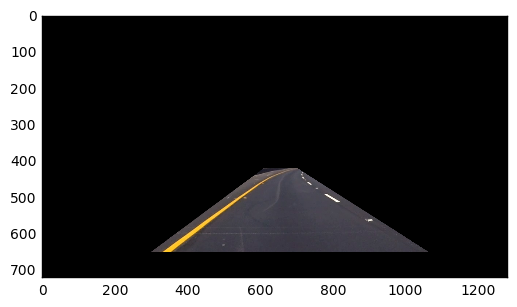

In [36]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(lambda img: process_image(img, parameters={'kernel_size': 5, 'vertices': np.array([[(300, 650), (610, 420), (700, 420), (1060, 650)]], dtype=np.int32)}))
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))